# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
% matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Understanding

Lets look at 3 different data set.

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.describe(), portfolio.shape

(       difficulty   duration     reward
 count   10.000000  10.000000  10.000000
 mean     7.700000   6.500000   4.200000
 std      5.831905   2.321398   3.583915
 min      0.000000   3.000000   0.000000
 25%      5.000000   5.000000   2.000000
 50%      8.500000   7.000000   4.000000
 75%     10.000000   7.000000   5.000000
 max     20.000000  10.000000  10.000000, (10, 6))

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
profile.describe(), profile.shape

(                age  became_member_on         income
 count  17000.000000      1.700000e+04   14825.000000
 mean      62.531412      2.016703e+07   65404.991568
 std       26.738580      1.167750e+04   21598.299410
 min       18.000000      2.013073e+07   30000.000000
 25%       45.000000      2.016053e+07   49000.000000
 50%       58.000000      2.017080e+07   64000.000000
 75%       73.000000      2.017123e+07   80000.000000
 max      118.000000      2.018073e+07  120000.000000, (17000, 5))

In [8]:
profile[profile['income'].isnull()].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [9]:
profile[profile['gender'].isnull()].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [10]:
profile.duplicated().sum()

0

In [11]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

So we can say that 2175 of 17000 rows have nulls for both gender and income. 

No duplicate row in profile data set.

In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
transcript.describe(), transcript.shape

(                time
 count  306534.000000
 mean      366.382940
 std       200.326314
 min         0.000000
 25%       186.000000
 50%       408.000000
 75%       528.000000
 max       714.000000, (306534, 4))

In [14]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [15]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

## Data cleaning

In [16]:
# convert day to hour

portfolio['duration']=portfolio['duration'] * 24
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [17]:
# rename id column to offer_id
portfolio=portfolio.rename(columns={'id':'offer_id'})

In [18]:
# one hot encoding for channel column
portfolio['email']=portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile']=portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social']=portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['web']=portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [19]:
portfolio.drop(['channels'], axis=1, inplace=True)
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


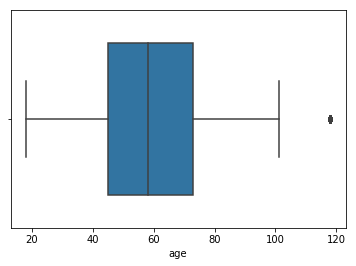

In [20]:
# check the outliers of age column
sns.boxplot(profile['age'], width=0.7);

In [21]:
check1= profile[profile['age']== 118]

In [22]:
check1.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [23]:
check1.describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [24]:
# So we have found that age 118 is a dummy input. As we saw before there are 2175 gender and income rows tha have no info. 

profile=profile[profile['age']<118].reset_index(drop=True)

In [25]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [26]:
profile.head()

,age,became_member_on,gender,id,income
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [27]:
# convert to date
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [28]:
# keep only year
profile['became_member_on']=pd.Series([int(str(x)[:4]) for x in profile['became_member_on']])

In [29]:
# rename column
profile=profile.rename(columns={'id':'customer_id'})

In [30]:
# divide value column into 2 due to different info
transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.value]

In [31]:
# rename
transcript=transcript.rename(columns={'person':'customer_id'})

In [32]:
# drop value column
transcript=transcript.drop(columns={'value'})

In [33]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [34]:
profile.head()

,age,became_member_on,gender,customer_id,income
0,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,2018,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,2018,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,2017,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [35]:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [36]:
# merge 1
df=pd.merge(profile,transcript, on='customer_id')

In [37]:
df.head()

,age,became_member_on,gender,customer_id,income,event,time,offer_id,amount
0,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,18,None,21.51
1,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,144,None,32.28
2,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,504,3f207df678b143eea3cee63160fa8bed,NaN
4,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,528,None,23.22


In [38]:
# renumber customer_id
customer_id_dict=df['customer_id'].unique()

In [39]:
# renumber offer_id
offer_id_dict=df['offer_id'].unique()

In [40]:
customer_id_dict = pd.Series(customer_id_dict).to_dict()
# https://www.geeksforgeeks.org/python-pandas-dataframe-to_dict/

In [41]:
customer_id_dict = dict([(v, k) for k, v in customer_id_dict.items()]) 
# https://stackoverflow.com/questions/1031851/how-do-i-exchange-keys-with-values-in-a-dictionary

In [42]:
offer_id_dict = pd.Series(offer_id_dict).to_dict()
offer_id_dict

{0: None,
 1: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 2: '3f207df678b143eea3cee63160fa8bed',
 3: '5a8bc65990b245e5a138643cd4eb9837',
 4: 'ae264e3637204a6fb9bb56bc8210ddfd',
 5: 'f19421c1d4aa40978ebb69ca19b0e20d',
 6: '2906b810c7d4411798c6938adc9daaa5',
 7: 'fafdcd668e3743c1bb461111dcafc2a4',
 8: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 9: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 10: '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [43]:
offer_id_dict = dict([(v, k) for k, v in offer_id_dict.items()]) 

In [44]:
df['customer_id']=df['customer_id'].map(customer_id_dict)

In [45]:
df['offer_id']=df['offer_id'].map(offer_id_dict)

In [46]:
portfolio['offer_id']=portfolio['offer_id'].map(offer_id_dict)

In [47]:
df.head()

,age,became_member_on,gender,customer_id,income,event,time,offer_id,amount
0,55,2017,F,0,112000.0,transaction,18,0,21.51
1,55,2017,F,0,112000.0,transaction,144,0,32.28
2,55,2017,F,0,112000.0,offer received,408,1,NaN
3,55,2017,F,0,112000.0,offer received,504,2,NaN
4,55,2017,F,0,112000.0,transaction,528,0,23.22


In [48]:
# df1 shows us the only offer's transactions
df1=pd.merge(df,portfolio, on='offer_id')

In [49]:
df1=df1.drop(columns={'amount'})

In [50]:
df2=df.drop(columns={'offer_id'})

In [51]:
# df3 shows us w/o any offers transactions so only transaction events
df3=df2.dropna(subset=['amount'])

In [52]:
df3.head()

,age,became_member_on,gender,customer_id,income,event,time,amount
0,55,2017,F,0,112000.0,transaction,18,21.51
1,55,2017,F,0,112000.0,transaction,144,32.28
4,55,2017,F,0,112000.0,transaction,528,23.22
8,75,2017,F,1,100000.0,transaction,132,19.89
10,75,2017,F,1,100000.0,transaction,144,17.78


In [53]:
df3.describe()

,age,became_member_on,customer_id,income,time,amount
count,123957.000000,123957.000000,123957.000000,123957.000000,123957.000000,123957.000000
mean,52.713965,2016.314666,7416.438079,61843.510250,381.278201,13.996325
std,17.906667,1.241192,4277.226631,20661.890394,201.829085,31.749420
min,18.000000,2013.000000,0.000000,30000.000000,0.000000,0.050000
25%,39.000000,2016.000000,3721.000000,46000.000000,210.000000,3.660000
50%,54.000000,2017.000000,7424.000000,60000.000000,402.000000,10.800000
75%,65.000000,2017.000000,11105.000000,74000.000000,552.000000,19.130000
max,101.000000,2018.000000,14824.000000,120000.000000,714.000000,1062.280000


In [54]:
df1.head()

,age,became_member_on,gender,customer_id,income,event,time,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017,F,0,112000.0,offer received,408,1,5,168,bogo,5,1,1,0,1
1,55,2017,F,0,112000.0,offer completed,528,1,5,168,bogo,5,1,1,0,1
2,75,2017,F,1,100000.0,offer received,0,1,5,168,bogo,5,1,1,0,1
3,75,2017,F,1,100000.0,offer viewed,6,1,5,168,bogo,5,1,1,0,1
4,75,2017,F,1,100000.0,offer completed,132,1,5,168,bogo,5,1,1,0,1


In [55]:
df1.shape

(148805, 16)

In [56]:
#check events
df1['event'].unique()

array(['offer received', 'offer completed', 'offer viewed'], dtype=object)

In [57]:
# df1 shows us the only offer's transactions
df1.describe()

,age,became_member_on,customer_id,income,time,offer_id,difficulty,duration,reward,email,mobile,social,web
count,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000
mean,54.779282,2016.576365,7408.517308,66414.119149,354.570223,5.706703,7.890561,159.004980,4.442445,1.0,0.917160,0.658311,0.806747
std,17.193533,1.186534,4278.063634,21496.947967,198.311301,2.796607,5.041335,51.192852,3.372362,0.0,0.275641,0.474277,0.394851
min,18.000000,2013.000000,0.000000,30000.000000,0.000000,1.000000,0.000000,72.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,43.000000,2016.000000,3705.000000,51000.000000,168.000000,4.000000,5.000000,120.000000,2.000000,1.0,1.000000,0.000000,1.000000
50%,56.000000,2017.000000,7400.000000,65000.000000,408.000000,6.000000,10.000000,168.000000,5.000000,1.0,1.000000,1.000000,1.000000
75%,67.000000,2017.000000,11110.000000,81000.000000,510.000000,8.000000,10.000000,168.000000,5.000000,1.0,1.000000,1.000000,1.000000
max,101.000000,2018.000000,14824.000000,120000.000000,714.000000,10.000000,20.000000,240.000000,10.000000,1.0,1.000000,1.000000,1.000000


In [58]:
# df shows us whole transactions
df.describe()

,age,became_member_on,customer_id,income,time,offer_id,amount
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,123957.000000
mean,53.840696,2016.457435,7412.116911,64337.000755,366.707694,3.113286,13.996325
std,17.551337,1.218663,4277.677254,21243.762941,200.359087,3.512949,31.749420
min,18.000000,2013.000000,0.000000,30000.000000,0.000000,0.000000,0.050000
25%,41.000000,2016.000000,3712.000000,48000.000000,186.000000,0.000000,3.660000
50%,55.000000,2017.000000,7409.000000,62000.000000,408.000000,1.000000,10.800000
75%,66.000000,2017.000000,11109.000000,78000.000000,528.000000,6.000000,19.130000
max,101.000000,2018.000000,14824.000000,120000.000000,714.000000,10.000000,1062.280000


In [59]:
# df3 shows us w/o any offers transactions
df3.describe()

,age,became_member_on,customer_id,income,time,amount
count,123957.000000,123957.000000,123957.000000,123957.000000,123957.000000,123957.000000
mean,52.713965,2016.314666,7416.438079,61843.510250,381.278201,13.996325
std,17.906667,1.241192,4277.226631,20661.890394,201.829085,31.749420
min,18.000000,2013.000000,0.000000,30000.000000,0.000000,0.050000
25%,39.000000,2016.000000,3721.000000,46000.000000,210.000000,3.660000
50%,54.000000,2017.000000,7424.000000,60000.000000,402.000000,10.800000
75%,65.000000,2017.000000,11105.000000,74000.000000,552.000000,19.130000
max,101.000000,2018.000000,14824.000000,120000.000000,714.000000,1062.280000


## Additional data cleaning process to be added for modelling. I think that heuristic approach will be enough but to complete the project I need metrics.

In [60]:
df1_model=df1.copy(deep = True)

In [61]:
df1_model["gender"][df1_model["gender"] == "M"] = 1
df1_model["gender"][df1_model["gender"] == "F"] = -1
df1_model["gender"][df1_model["gender"] == "O"] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
df1_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 16 columns):
age                 148805 non-null int64
became_member_on    148805 non-null int64
gender              148805 non-null object
customer_id         148805 non-null int64
income              148805 non-null float64
event               148805 non-null object
time                148805 non-null int64
offer_id            148805 non-null int64
difficulty          148805 non-null int64
duration            148805 non-null int64
offer_type          148805 non-null object
reward              148805 non-null int64
email               148805 non-null int64
mobile              148805 non-null int64
social              148805 non-null int64
web                 148805 non-null int64
dtypes: float64(1), int64(12), object(3)
memory usage: 19.3+ MB


In [63]:
df1_model.head()

,age,became_member_on,gender,customer_id,income,event,time,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017,-1,0,112000.0,offer received,408,1,5,168,bogo,5,1,1,0,1
1,55,2017,-1,0,112000.0,offer completed,528,1,5,168,bogo,5,1,1,0,1
2,75,2017,-1,1,100000.0,offer received,0,1,5,168,bogo,5,1,1,0,1
3,75,2017,-1,1,100000.0,offer viewed,6,1,5,168,bogo,5,1,1,0,1
4,75,2017,-1,1,100000.0,offer completed,132,1,5,168,bogo,5,1,1,0,1


In [64]:
df1.head()

,age,became_member_on,gender,customer_id,income,event,time,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017,F,0,112000.0,offer received,408,1,5,168,bogo,5,1,1,0,1
1,55,2017,F,0,112000.0,offer completed,528,1,5,168,bogo,5,1,1,0,1
2,75,2017,F,1,100000.0,offer received,0,1,5,168,bogo,5,1,1,0,1
3,75,2017,F,1,100000.0,offer viewed,6,1,5,168,bogo,5,1,1,0,1
4,75,2017,F,1,100000.0,offer completed,132,1,5,168,bogo,5,1,1,0,1


In [65]:
offer_type_dict=df1_model['offer_type'].unique()

In [66]:
offer_type_dict

array(['bogo', 'informational', 'discount'], dtype=object)

In [67]:
df1_model["offer_type"][df1_model["offer_type"] == "bogo"] = 1
df1_model["offer_type"][df1_model["offer_type"] == "informational"] = -1
df1_model["offer_type"][df1_model["offer_type"] == "discount"] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
#encode 'event' data to numerical values according to task 2
df1_model['event'] = df1_model['event'].map({'offer received':0, 'offer viewed':1, 'offer completed':2})

In [69]:
df1_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 16 columns):
age                 148805 non-null int64
became_member_on    148805 non-null int64
gender              148805 non-null object
customer_id         148805 non-null int64
income              148805 non-null float64
event               148805 non-null int64
time                148805 non-null int64
offer_id            148805 non-null int64
difficulty          148805 non-null int64
duration            148805 non-null int64
offer_type          148805 non-null object
reward              148805 non-null int64
email               148805 non-null int64
mobile              148805 non-null int64
social              148805 non-null int64
web                 148805 non-null int64
dtypes: float64(1), int64(13), object(2)
memory usage: 19.3+ MB


In [70]:
df1_model.head()

,age,became_member_on,gender,customer_id,income,event,time,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017,-1,0,112000.0,0,408,1,5,168,1,5,1,1,0,1
1,55,2017,-1,0,112000.0,2,528,1,5,168,1,5,1,1,0,1
2,75,2017,-1,1,100000.0,0,0,1,5,168,1,5,1,1,0,1
3,75,2017,-1,1,100000.0,1,6,1,5,168,1,5,1,1,0,1
4,75,2017,-1,1,100000.0,2,132,1,5,168,1,5,1,1,0,1


In [71]:
df1_model = df1_model.drop(columns = ["customer_id","email","mobile","social","web"])


In [72]:
df1_model.head()

,age,became_member_on,gender,income,event,time,offer_id,difficulty,duration,offer_type,reward
0,55,2017,-1,112000.0,0,408,1,5,168,1,5
1,55,2017,-1,112000.0,2,528,1,5,168,1,5
2,75,2017,-1,100000.0,0,0,1,5,168,1,5
3,75,2017,-1,100000.0,1,6,1,5,168,1,5
4,75,2017,-1,100000.0,2,132,1,5,168,1,5


In [73]:
df1.head()

,age,became_member_on,gender,customer_id,income,event,time,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,55,2017,F,0,112000.0,offer received,408,1,5,168,bogo,5,1,1,0,1
1,55,2017,F,0,112000.0,offer completed,528,1,5,168,bogo,5,1,1,0,1
2,75,2017,F,1,100000.0,offer received,0,1,5,168,bogo,5,1,1,0,1
3,75,2017,F,1,100000.0,offer viewed,6,1,5,168,bogo,5,1,1,0,1
4,75,2017,F,1,100000.0,offer completed,132,1,5,168,bogo,5,1,1,0,1


## As we see on df1 and df3 statistics, we can say that offers sent and transactions have nearly same characteristics. I will check them again on below graphs also.

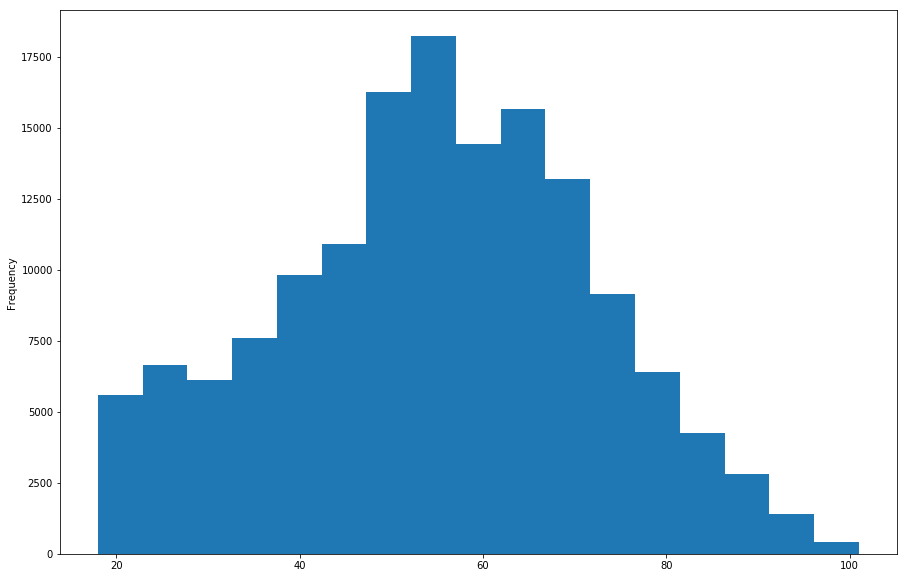

In [74]:
plt.figure(figsize=(15, 10));
df1['age'].plot(kind='hist', bins=17);

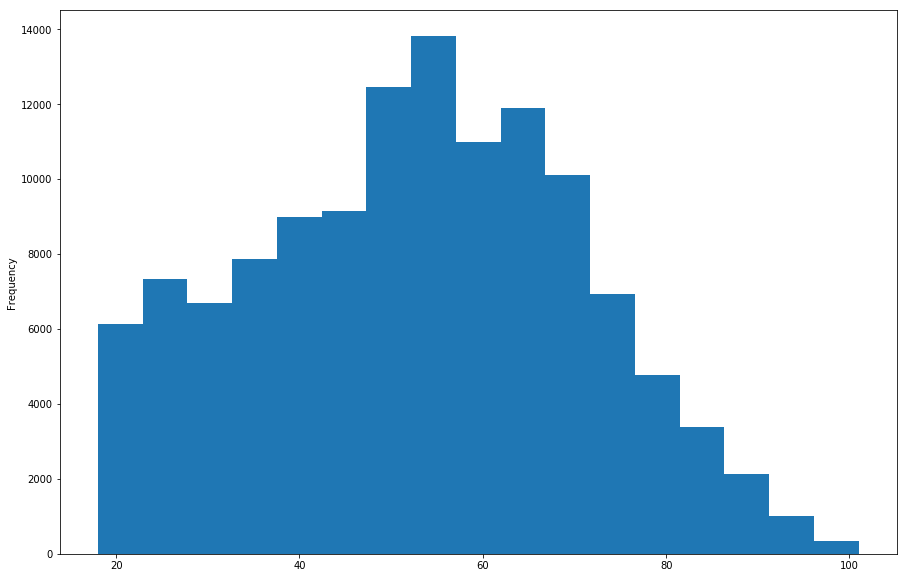

In [75]:
plt.figure(figsize=(15, 10));
df3['age'].plot(kind='hist', bins=17);

## Age distribution is same for 2 datasets.

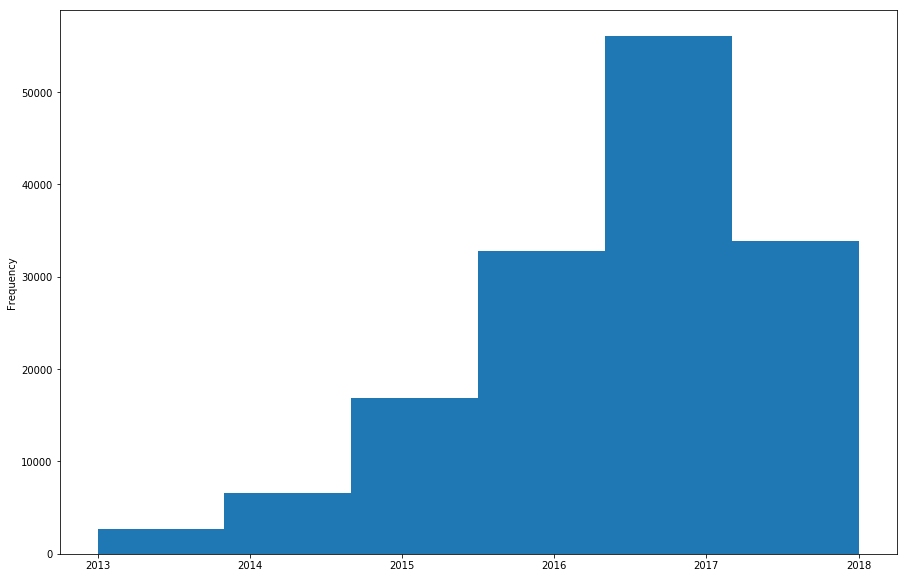

In [76]:
plt.figure(figsize=(15, 10));
df1['became_member_on'].plot(kind='hist', bins=6);

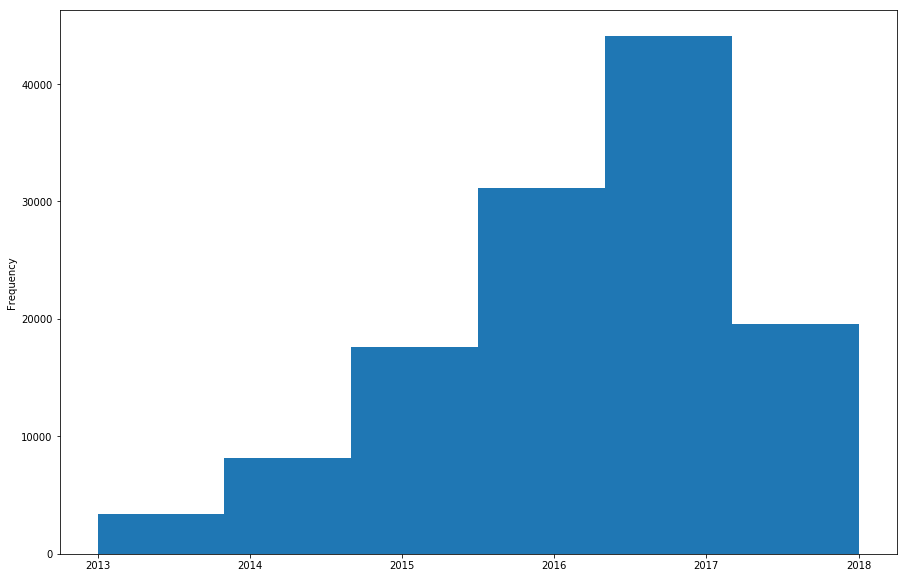

In [77]:
plt.figure(figsize=(15, 10));
df3['became_member_on'].plot(kind='hist', bins=6);

## became member year distribution is same for 2 datasets.

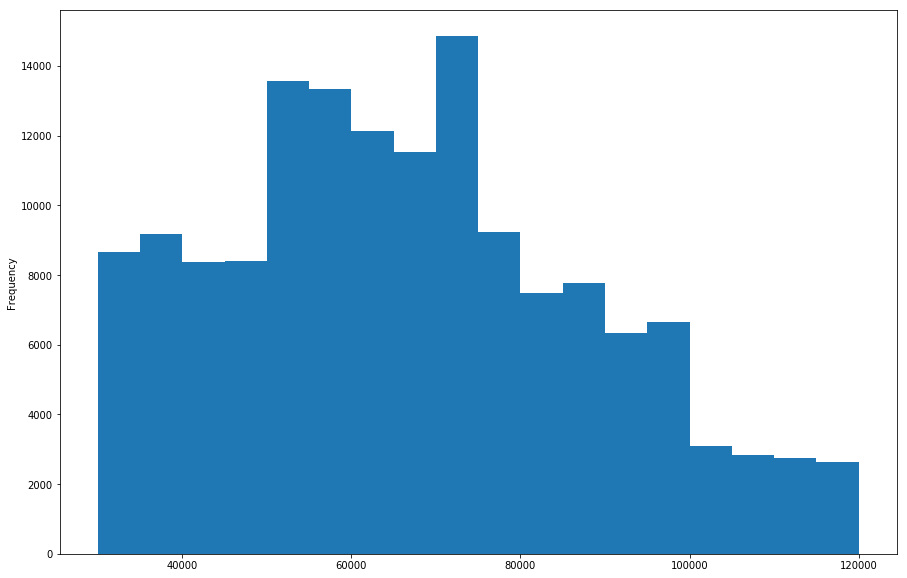

In [78]:
plt.figure(figsize=(15, 10));
df1['income'].plot(kind='hist', bins=18);

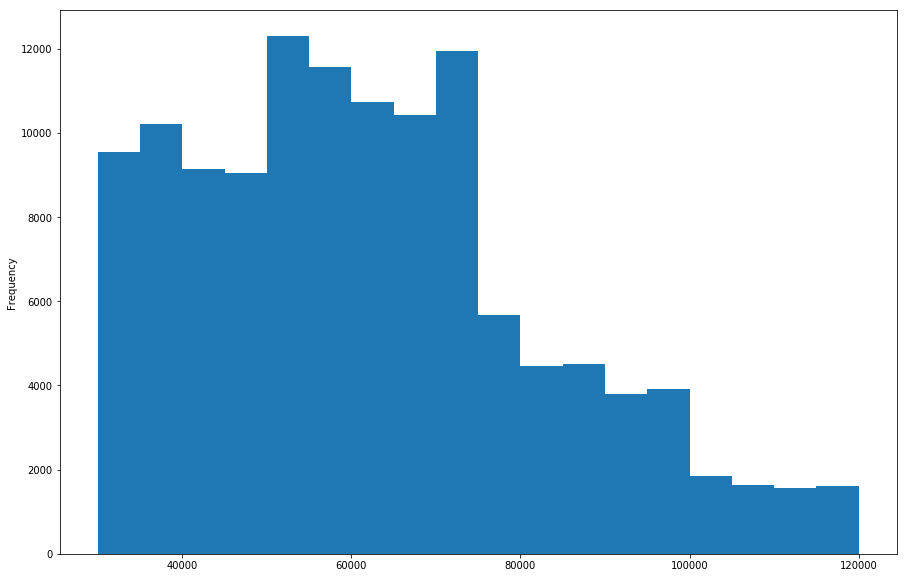

In [79]:
plt.figure(figsize=(15, 10));
df3['income'].plot(kind='hist', bins=18);

## Income has quite different especially higher than 75K for 2 datasets. So that means Starbucks sent more offers as a percentage to 75to100K income customers. They targetted this customer set.

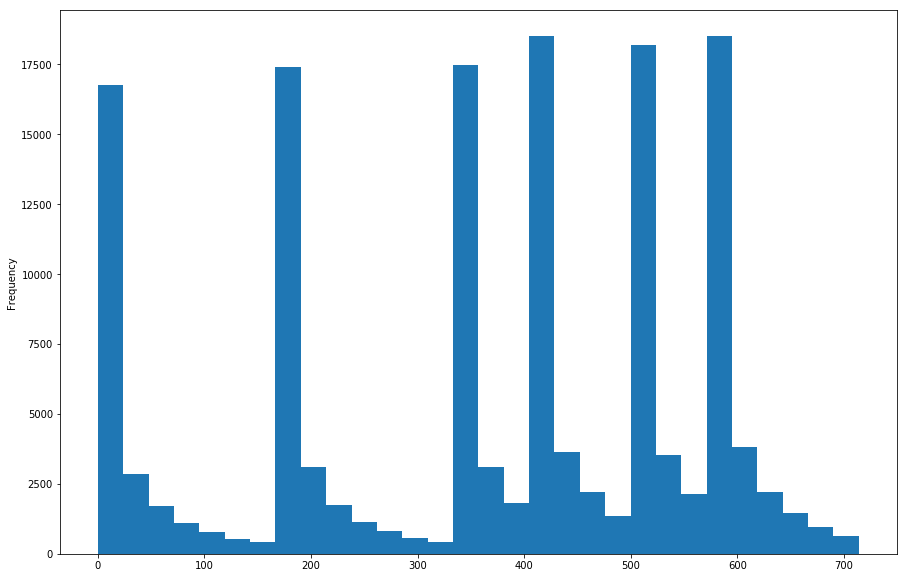

In [80]:
plt.figure(figsize=(15, 10));
df1['time'].plot(kind='hist', bins=30);

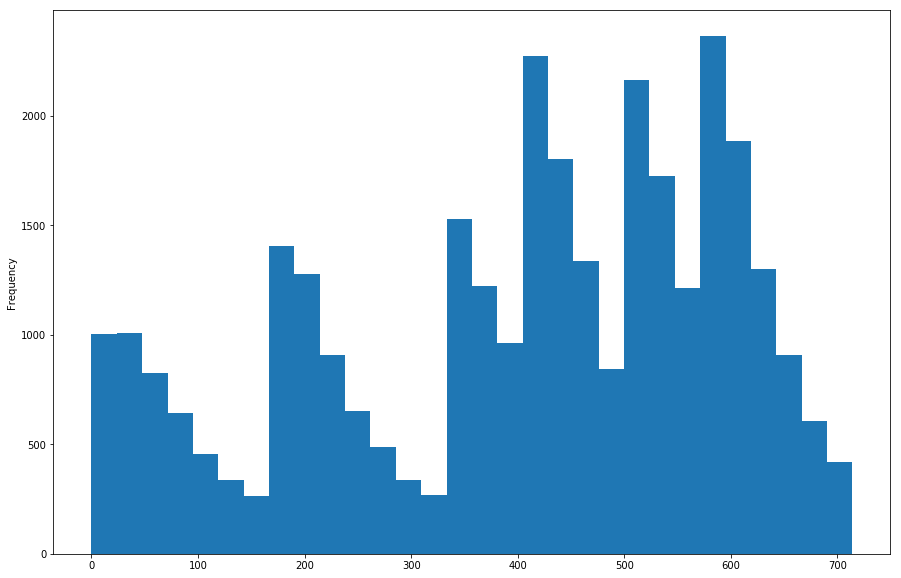

In [81]:
plt.figure(figsize=(15, 10));
df1[df1['event']=="offer completed"]['time'].plot(kind='hist', bins=30);

## When we check the above and below graphs, we can say that offers were not sent every day. The interval was decreased after 2nd offer. On the other hand, offer receivals are going to decrease after day 0 continuously.

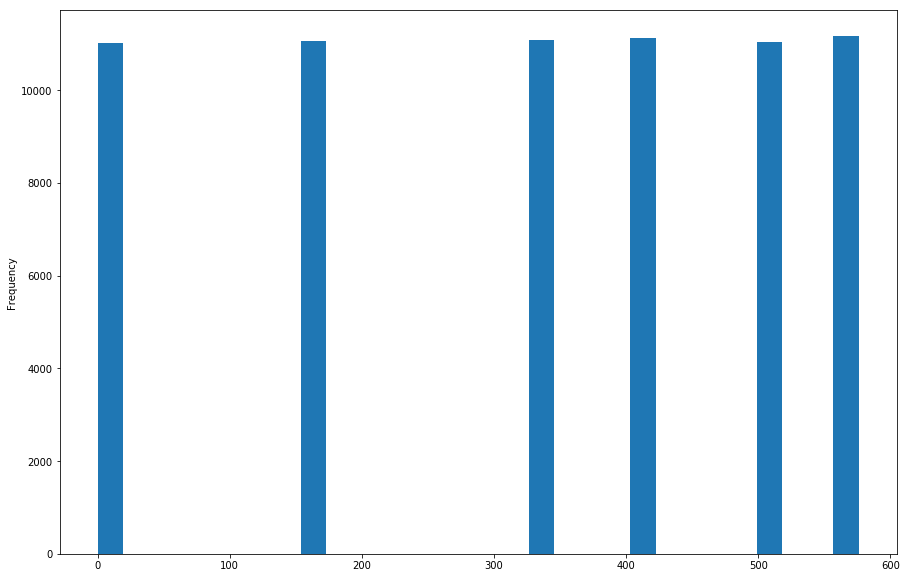

In [82]:
plt.figure(figsize=(15, 10));
df1[df1['event']=="offer received"]['time'].plot(kind='hist', bins=30);

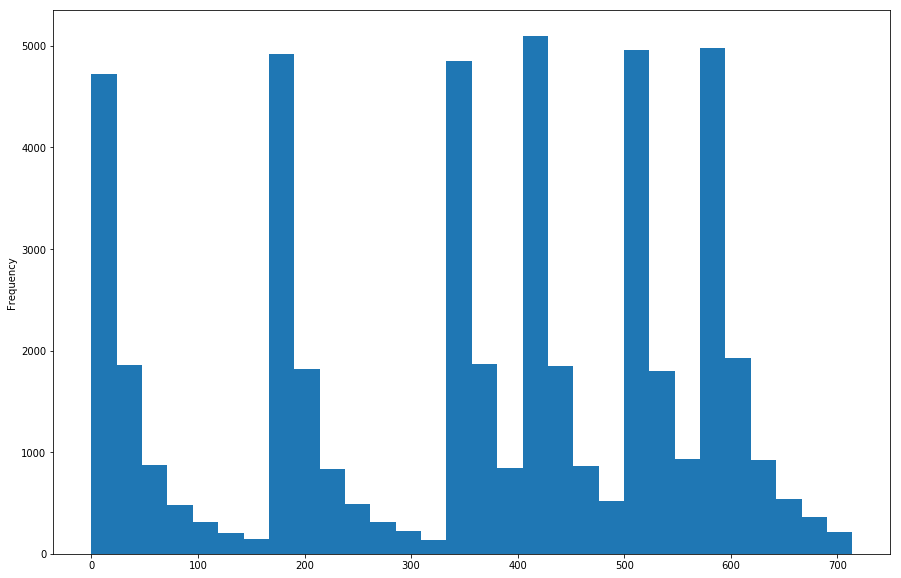

In [83]:
plt.figure(figsize=(15, 10));

df1[df1['event']=="offer viewed"]['time'].plot(kind='hist', bins=30);

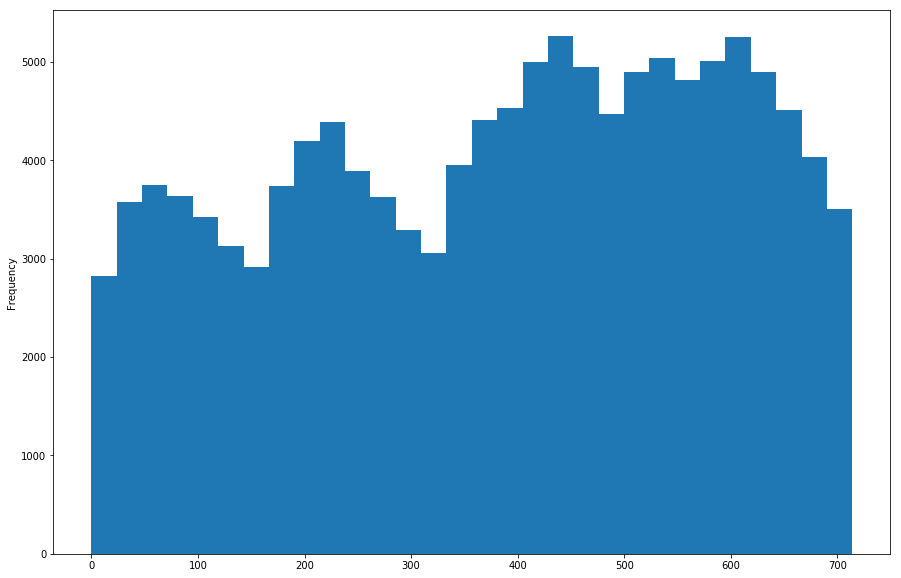

In [84]:
plt.figure(figsize=(15, 10));

df3['time'].plot(kind='hist', bins=30);

## Transactions w/o offers has increased with the increased frequency of offers. **

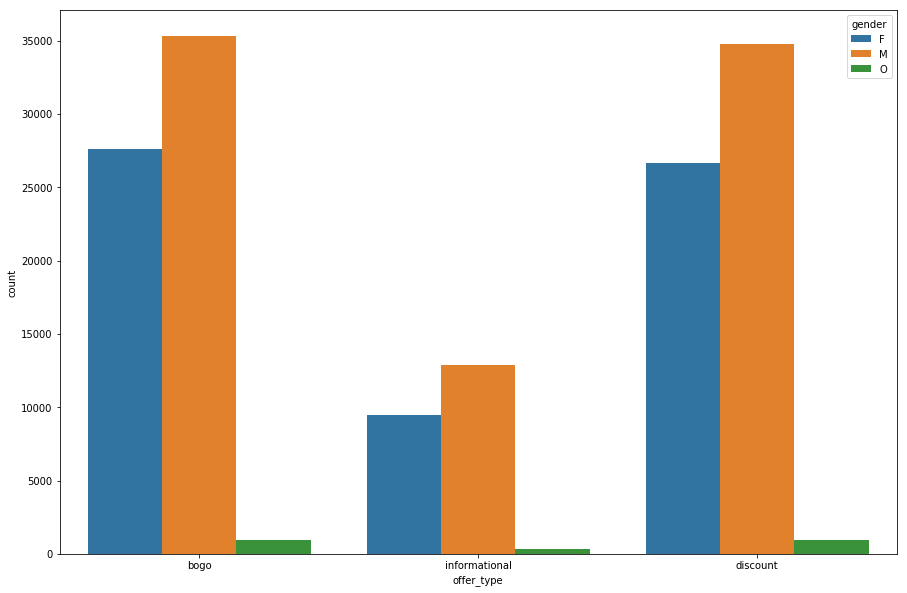

In [85]:
plt.figure(figsize=(15, 10));

sns.countplot(x="offer_type", hue="gender", data=df1);

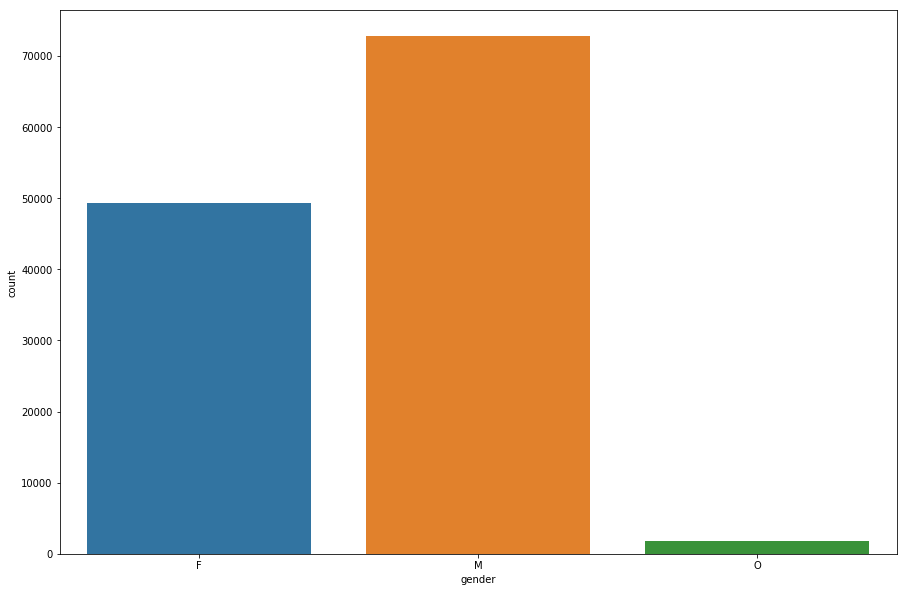

In [86]:
plt.figure(figsize=(15, 10));

sns.countplot(x="gender", data=df3);

## In quantity wise, men get more offer than women.

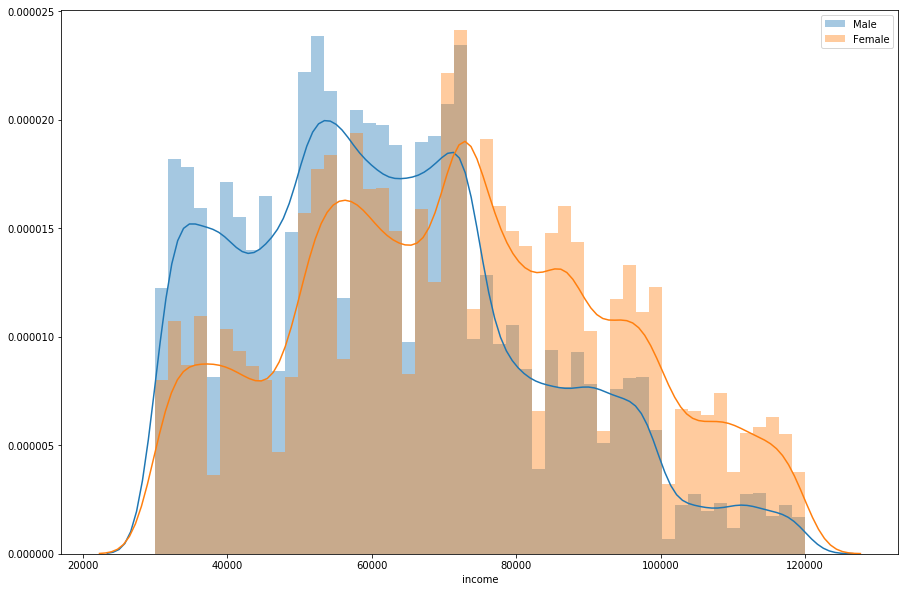

In [87]:
plt.figure(figsize=(15, 10));

sns.distplot(df1[df1.gender=='M'].income,label='Male')
sns.distplot(df1[df1.gender=='F'].income,label='Female')
plt.legend()
plt.show()

## Women has higher income than men according to distribution results.

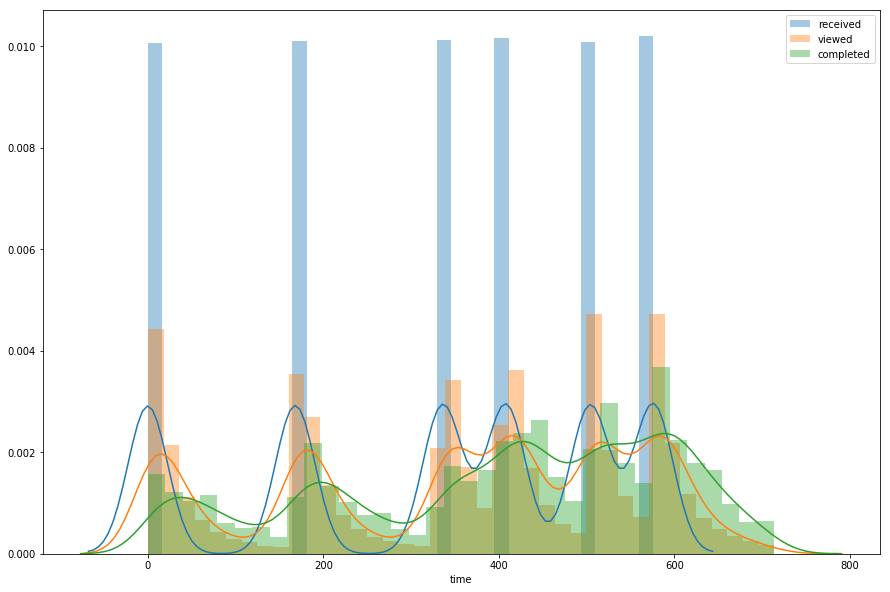

In [88]:
plt.figure(figsize=(15, 10));

sns.distplot(df1[df1.event=='offer received'].time,label='received')
sns.distplot(df1[df1.event=='offer viewed'].time,label='viewed')
sns.distplot(df1[df1.event=='offer completed'].time,label='completed')


plt.legend()
plt.show()

#sns.distplot(df1[df1.event=='transaction'].time,label='transaction')

#plt.legend()
#plt.show()

#'offer received', 'offer viewed', 'transaction', 'offer completed'

## Increased offer frequency increases the completion ratio.

Text(0.5,0,'Offers')

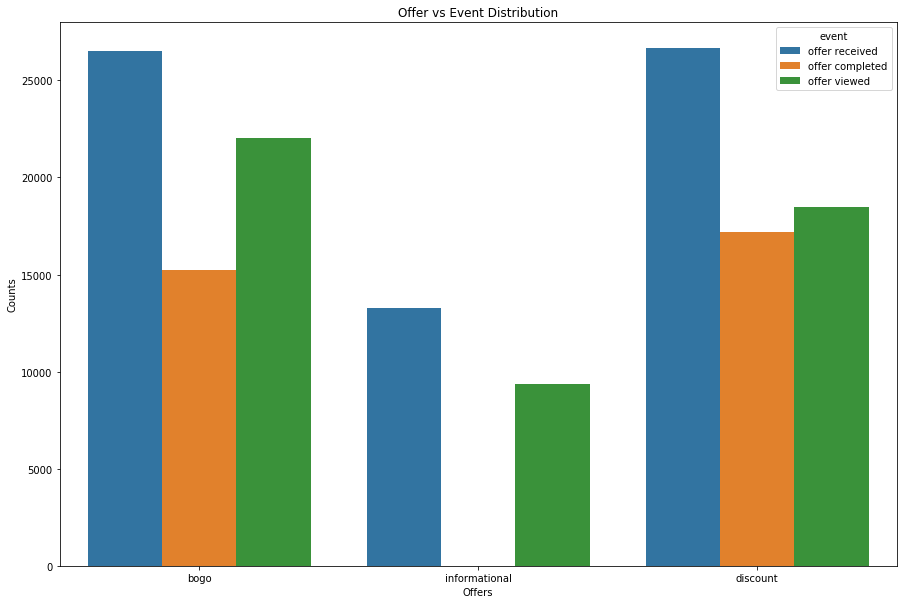

In [89]:
plt.figure(figsize=(15, 10));
sns.countplot(x= "offer_type", hue= "event", data=df1)
plt.title('Offer vs Event Distribution')
plt.ylabel('Counts')
plt.xlabel('Offers')

## Discount and bogo offers have same quantity. Bogo offers views are higher than discount on the other hand discount completion rate is higher.

Text(0.5,0,'Offers')

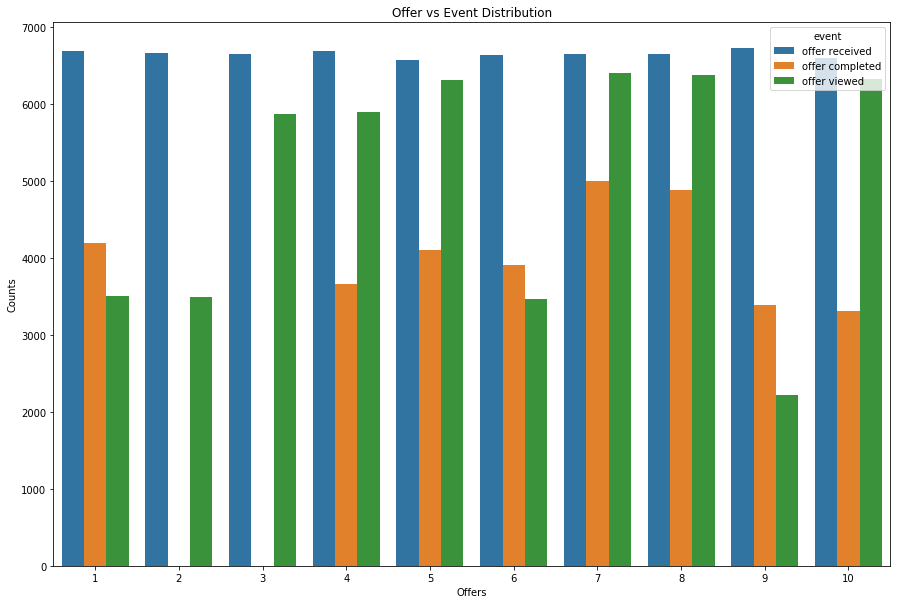

In [90]:
#offer_id
plt.figure(figsize=(15, 10));
sns.countplot(x= "offer_id", hue= "event", data=df1)
plt.title('Offer vs Event Distribution')
plt.ylabel('Counts')
plt.xlabel('Offers')

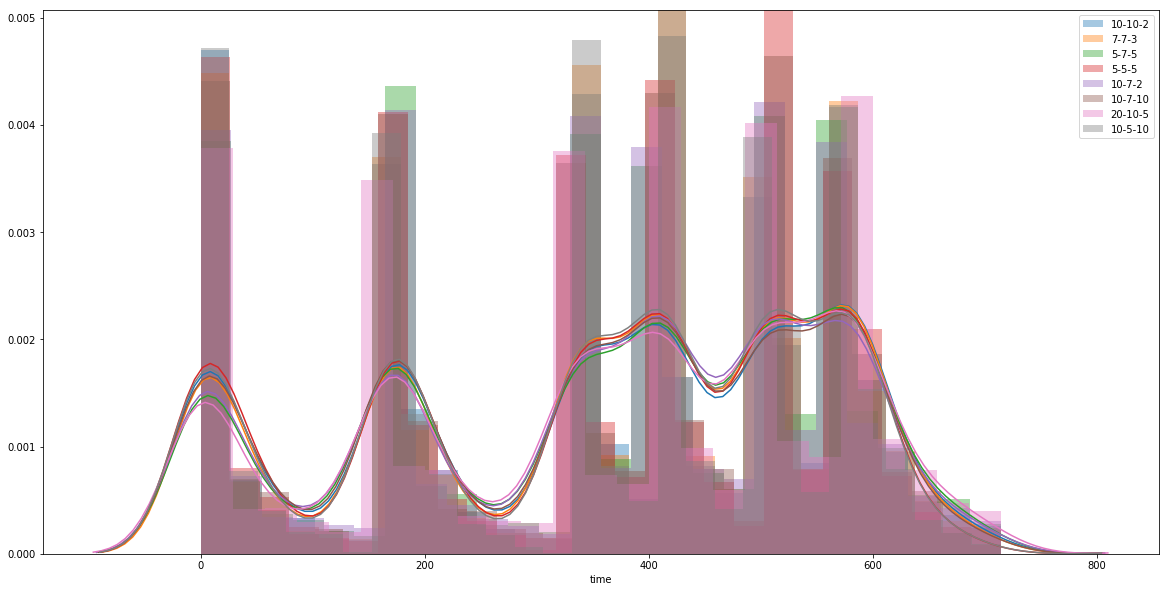

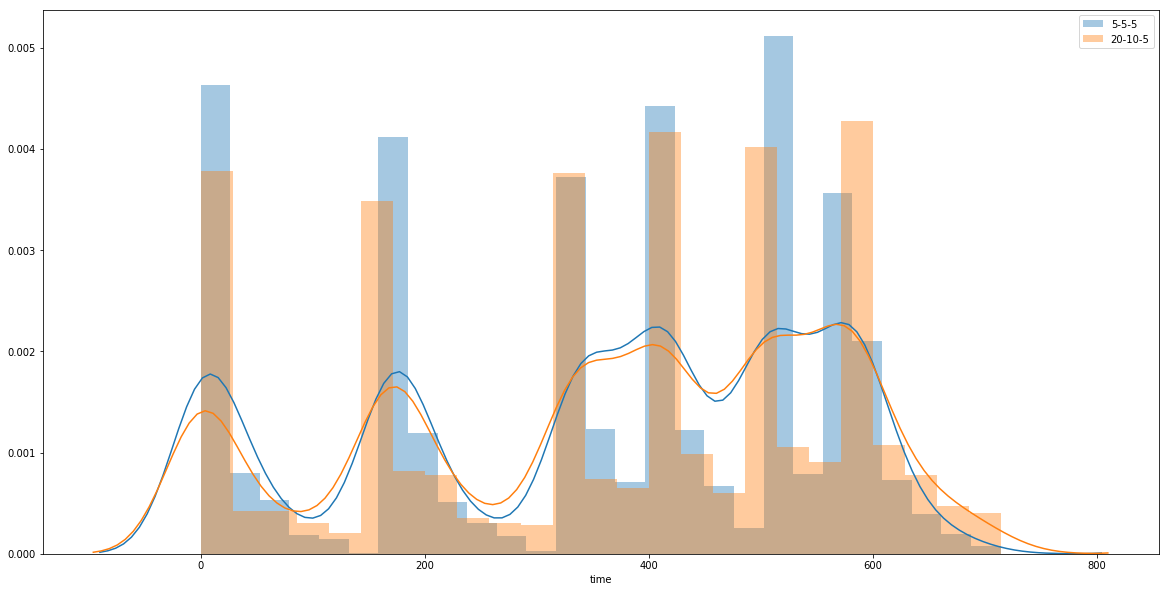

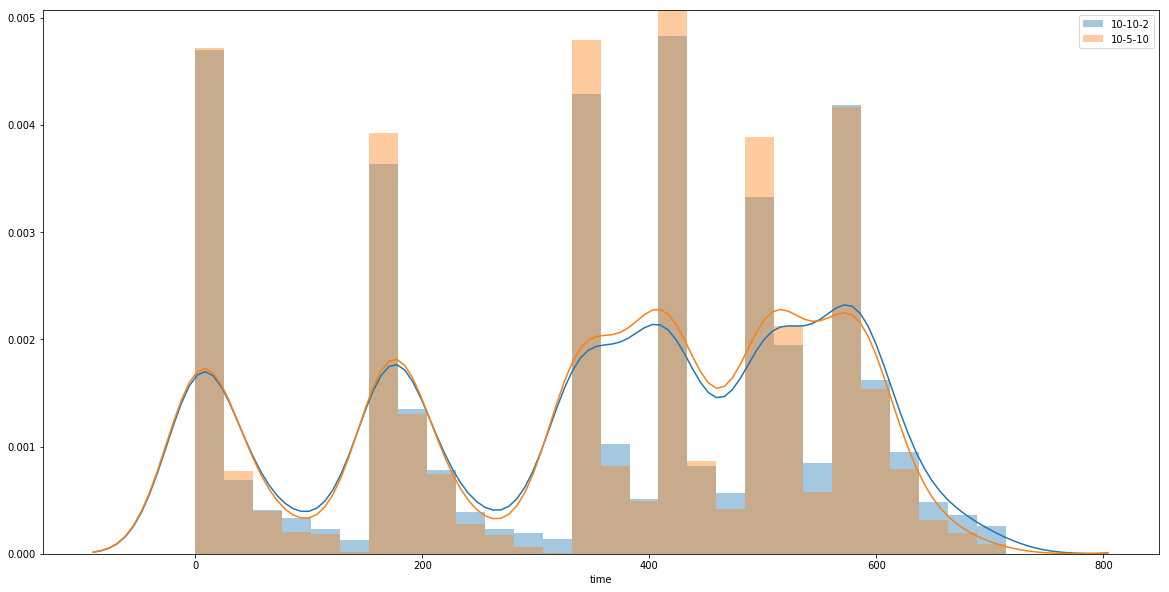

In [91]:
# I have labeled the items difficulty, duration and reward respectively. I queue them according to completion ratio.
plt.figure(figsize=(20, 10));

sns.distplot(df1[df1.offer_id==7].time,label='10-10-2')
sns.distplot(df1[df1.offer_id==8].time,label='7-7-3')
sns.distplot(df1[df1.offer_id==1].time,label='5-7-5')
sns.distplot(df1[df1.offer_id==5].time,label='5-5-5')
sns.distplot(df1[df1.offer_id==6].time,label='10-7-2')
sns.distplot(df1[df1.offer_id==4].time,label='10-7-10')
sns.distplot(df1[df1.offer_id==9].time,label='20-10-5')
sns.distplot(df1[df1.offer_id==10].time,label='10-5-10')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10));

sns.distplot(df1[df1.offer_id==5].time,label='5-5-5')
sns.distplot(df1[df1.offer_id==9].time,label='20-10-5')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10));


sns.distplot(df1[df1.offer_id==7].time,label='10-10-2')
sns.distplot(df1[df1.offer_id==10].time,label='10-5-10')
plt.legend()
plt.show()



## When difficuilty is getting higher the offer completion ratio is worsen as expected for 5 and 10 day durations. 
## On the other hand, if the duration is 7 days then the results is not correlated with difficulty even difficult ones has less rewards. I will investigate 7 days durations in detail to understand.
## If other than duration is same, then completion is getting higher when duration increases as expected.

In [92]:
df_or= df1[df1['event']== 'offer received']
df_ov= df1[df1['event']== 'offer viewed']
df_oc= df1[df1['event']== 'offer completed']


In [93]:
df_or.describe()

,age,became_member_on,customer_id,income,time,offer_id,difficulty,duration,reward,email,mobile,social,web
count,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.00000,66501.000000,66501.000000,66501.0,66501.000000,66501.000000,66501.000000
mean,54.369258,2016.622021,7410.574307,65371.618472,332.610818,5.497571,7.71417,156.181712,4.198824,1.0,0.898859,0.598517,0.799612
std,17.395430,1.198364,4277.552904,21623.288473,196.528671,2.873888,5.54754,52.905986,3.398100,0.0,0.301518,0.490202,0.400294
min,18.000000,2013.000000,0.000000,30000.000000,0.000000,1.000000,0.00000,72.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,42.000000,2016.000000,3709.000000,49000.000000,168.000000,3.000000,5.00000,120.000000,2.000000,1.0,1.000000,0.000000,1.000000
50%,55.000000,2017.000000,7404.000000,64000.000000,408.000000,6.000000,10.00000,168.000000,5.000000,1.0,1.000000,1.000000,1.000000
75%,66.000000,2017.000000,11114.000000,80000.000000,504.000000,8.000000,10.00000,168.000000,5.000000,1.0,1.000000,1.000000,1.000000
max,101.000000,2018.000000,14824.000000,120000.000000,576.000000,10.000000,20.00000,240.000000,10.000000,1.0,1.000000,1.000000,1.000000


In [94]:
df_ov.describe()

,age,became_member_on,customer_id,income,time,offer_id,difficulty,duration,reward,email,mobile,social,web
count,49860.000000,49860.000000,49860.000000,49860.000000,49860.000000,49860.000000,49860.000000,49860.000000,49860.000000,49860.0,49860.000000,49860.000000,49860.000000
mean,54.644645,2016.612395,7413.733855,65841.596470,354.547533,5.678139,7.199519,151.939832,4.438247,1.0,0.955576,0.746069,0.763859
std,17.142283,1.197056,4275.982584,21075.168266,199.405552,2.738804,4.630599,51.678837,3.578100,0.0,0.206038,0.435263,0.424714
min,18.000000,2013.000000,1.000000,30000.000000,0.000000,1.000000,0.000000,72.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,43.000000,2016.000000,3711.000000,51000.000000,180.000000,3.000000,5.000000,120.000000,2.000000,1.0,1.000000,0.000000,1.000000
50%,55.000000,2017.000000,7410.000000,64000.000000,408.000000,5.000000,7.000000,168.000000,3.000000,1.0,1.000000,1.000000,1.000000
75%,66.250000,2017.000000,11123.250000,80000.000000,516.000000,8.000000,10.000000,168.000000,5.000000,1.0,1.000000,1.000000,1.000000
max,101.000000,2018.000000,14824.000000,120000.000000,714.000000,10.000000,20.000000,240.000000,10.000000,1.0,1.000000,1.000000,1.000000


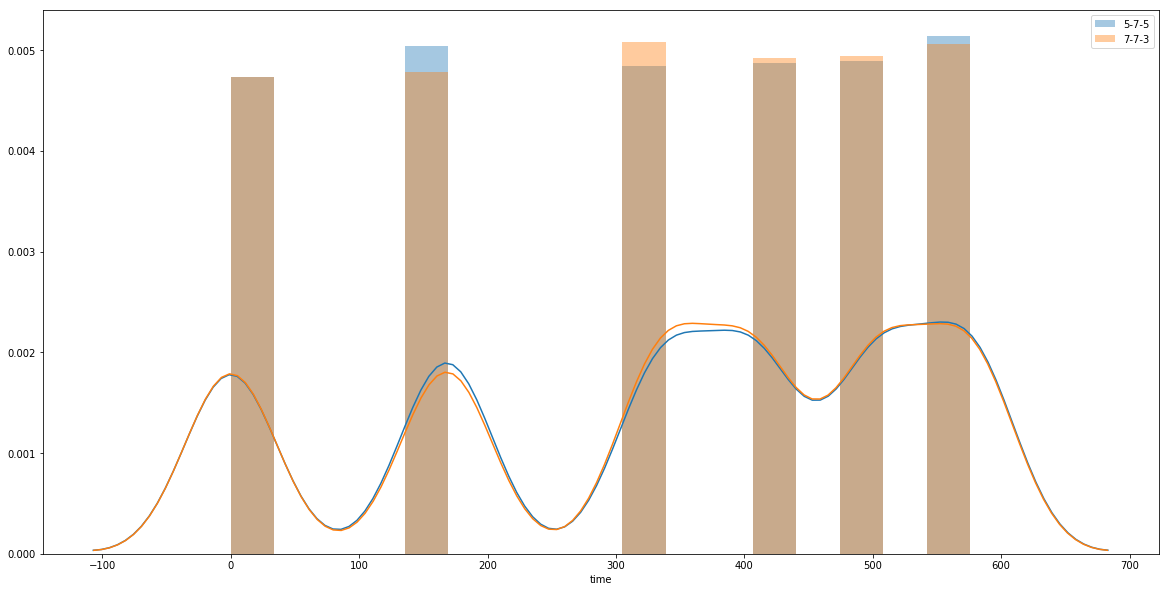

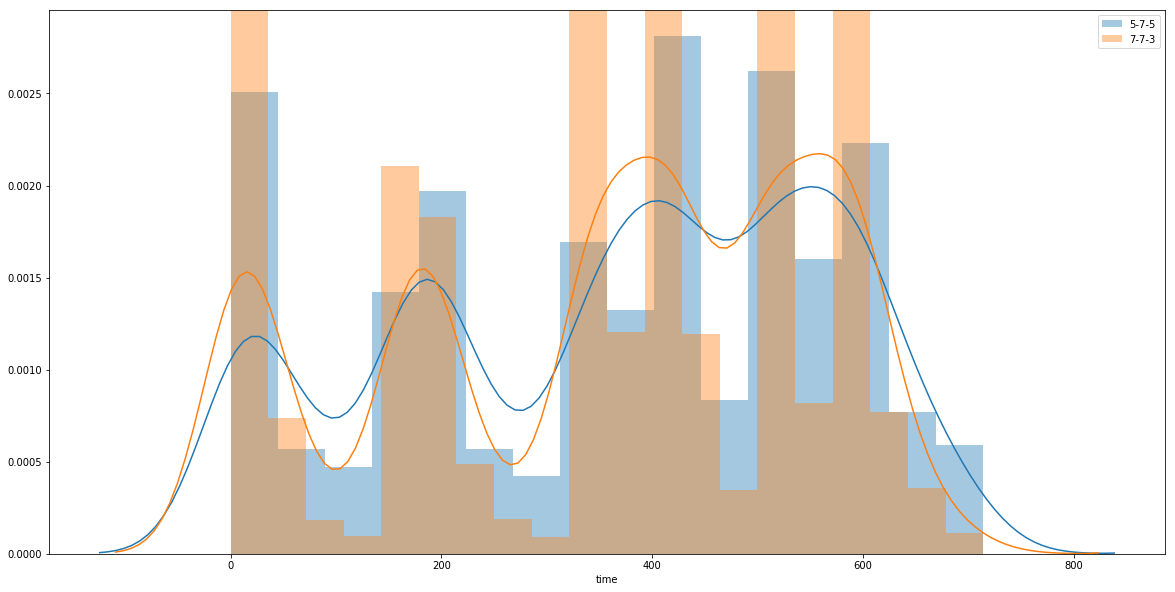

In [95]:
plt.figure(figsize=(20, 10));


sns.distplot(df_or[df_or.offer_id==1].time,label='5-7-5')
sns.distplot(df_or[df_or.offer_id==8].time,label='7-7-3')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10));


sns.distplot(df_ov[df_ov.offer_id==1].time,label='5-7-5')
sns.distplot(df_ov[df_ov.offer_id==8].time,label='7-7-3')
plt.legend()
plt.show()


## All offers are sent nearly same day so there is no difference according to time wise. On the other hand, there is no significant differences on statics between received and viewed ones. I could not detect why there is a difference of receivals ratio for 7 day duration events even it is not logical. I will have a look another parameters like gender on next analysis.

In [96]:
# I have divided the dataset acc to gender types.
df1_m=df1[df1['gender']=='M'].reset_index(drop=True)
df1_f=df1[df1['gender']=='F'].reset_index(drop=True)

Text(0.5,0,'Offers')

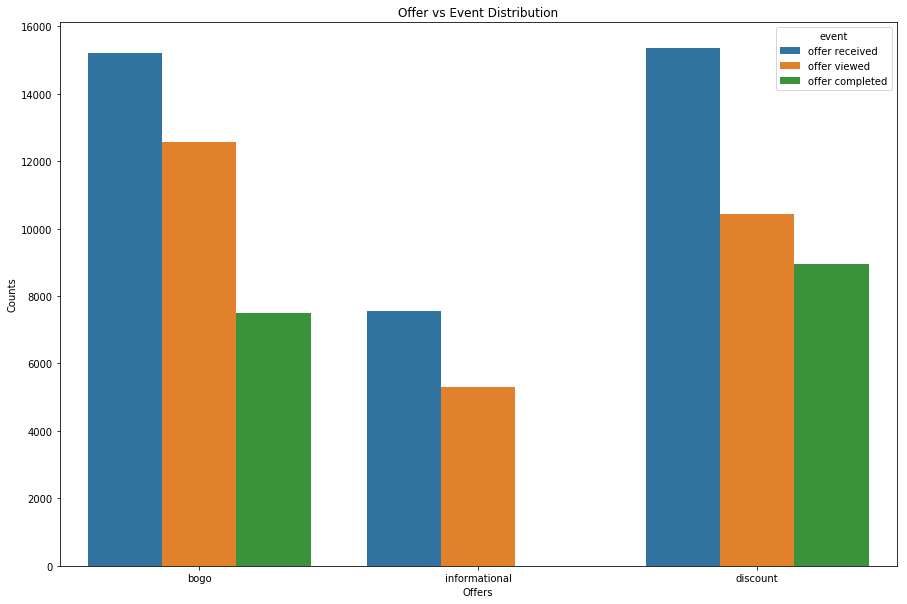

In [97]:
plt.figure(figsize=(15, 10));
sns.countplot(x= "offer_type", hue= "event", data=df1_m)
plt.title('Offer vs Event Distribution')
plt.ylabel('Counts')
plt.xlabel('Offers')

Text(0.5,0,'Offers')

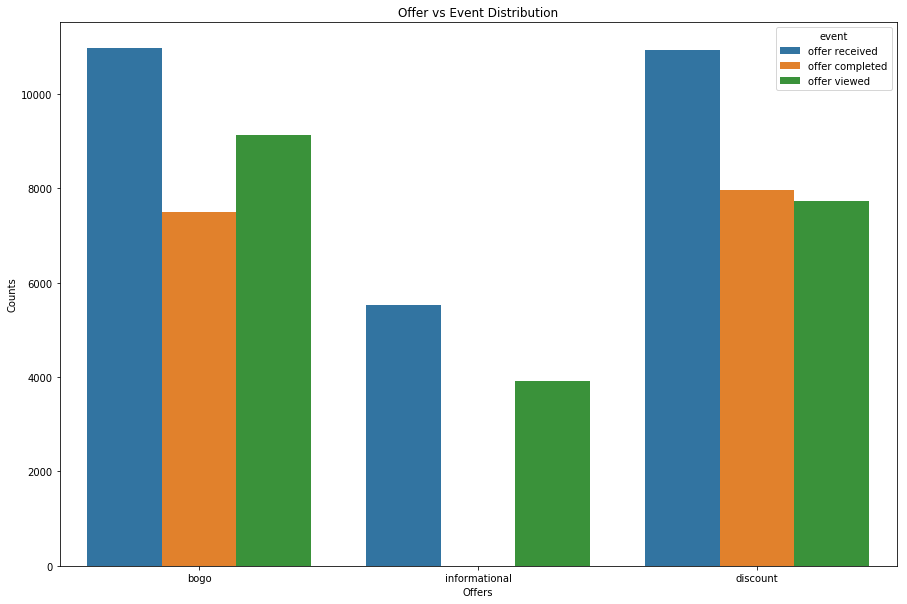

In [98]:
plt.figure(figsize=(15, 10));
sns.countplot(x= "offer_type", hue= "event", data=df1_f)
plt.title('Offer vs Event Distribution')
plt.ylabel('Counts')
plt.xlabel('Offers')

## Women completion ratio is significantly higher than men. Especially on discount, women completion ratio is higher than view. 

Text(0.5,0,'Offers')

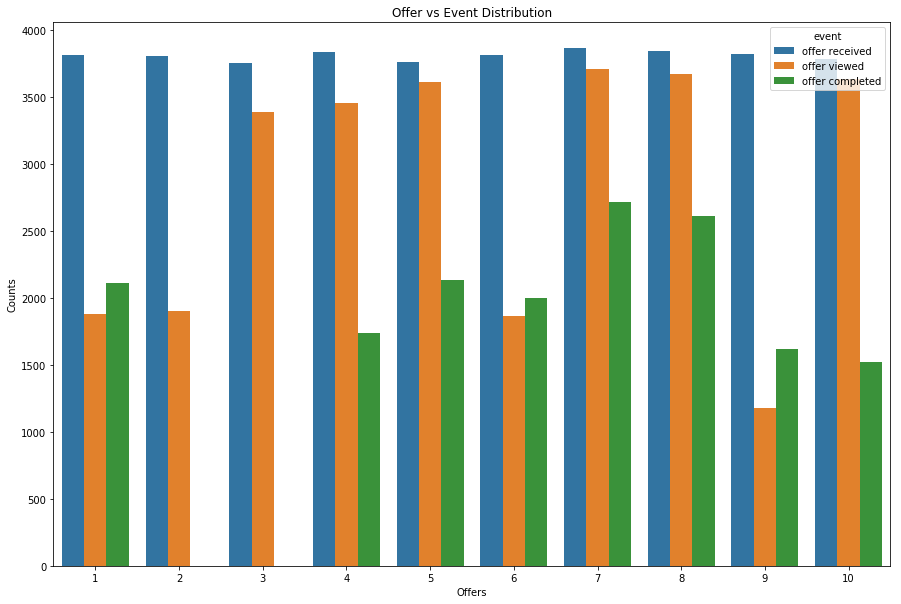

In [99]:
plt.figure(figsize=(15, 10));
sns.countplot(x= "offer_id", hue= "event", data=df1_m)
plt.title('Offer vs Event Distribution')
plt.ylabel('Counts')
plt.xlabel('Offers')

Text(0.5,0,'Offers')

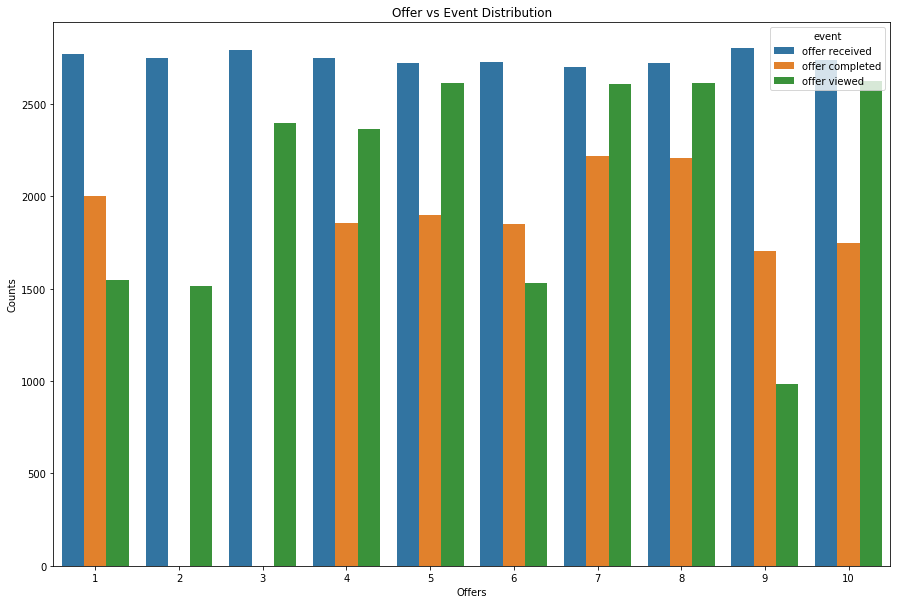

In [100]:
plt.figure(figsize=(15, 10));
sns.countplot(x= "offer_id", hue= "event", data=df1_f)
plt.title('Offer vs Event Distribution')
plt.ylabel('Counts')
plt.xlabel('Offers')

## Women and men have same top3 offer choice. 
## Womens have less sensitivity to offer type but offer type is important for men. If the difficult is higher than 1dolar per day then men's tendecy to complete offer decreases significantly.

In [101]:
# I have divided the dataset acc to gender types for 'offer completed' to understand the parameters' effect.
dfoc_m=df_oc[df_oc['gender']=='M'].reset_index(drop=True)
dfoc_f=df_oc[df_oc['gender']=='F'].reset_index(drop=True)

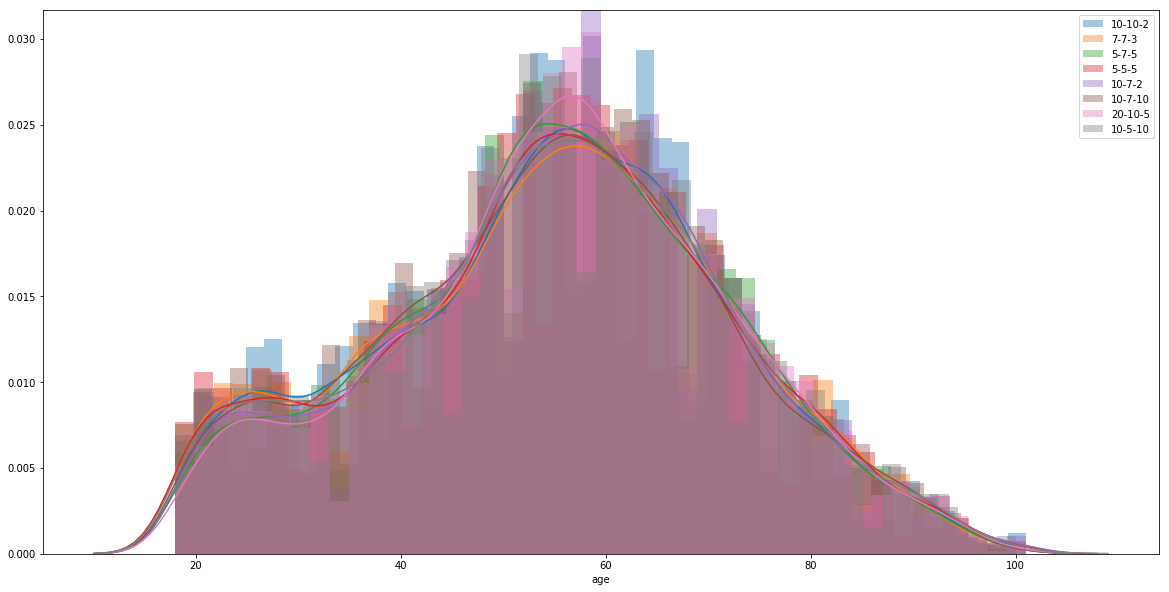

In [102]:
plt.figure(figsize=(20, 10));

sns.distplot(df1[df1.offer_id==7].age,label='10-10-2')
sns.distplot(df1[df1.offer_id==8].age,label='7-7-3')
sns.distplot(df1[df1.offer_id==1].age,label='5-7-5')
sns.distplot(df1[df1.offer_id==5].age,label='5-5-5')
sns.distplot(df1[df1.offer_id==6].age,label='10-7-2')
sns.distplot(df1[df1.offer_id==4].age,label='10-7-10')
sns.distplot(df1[df1.offer_id==9].age,label='20-10-5')
sns.distplot(df1[df1.offer_id==10].age,label='10-5-10')
plt.legend()
plt.show()

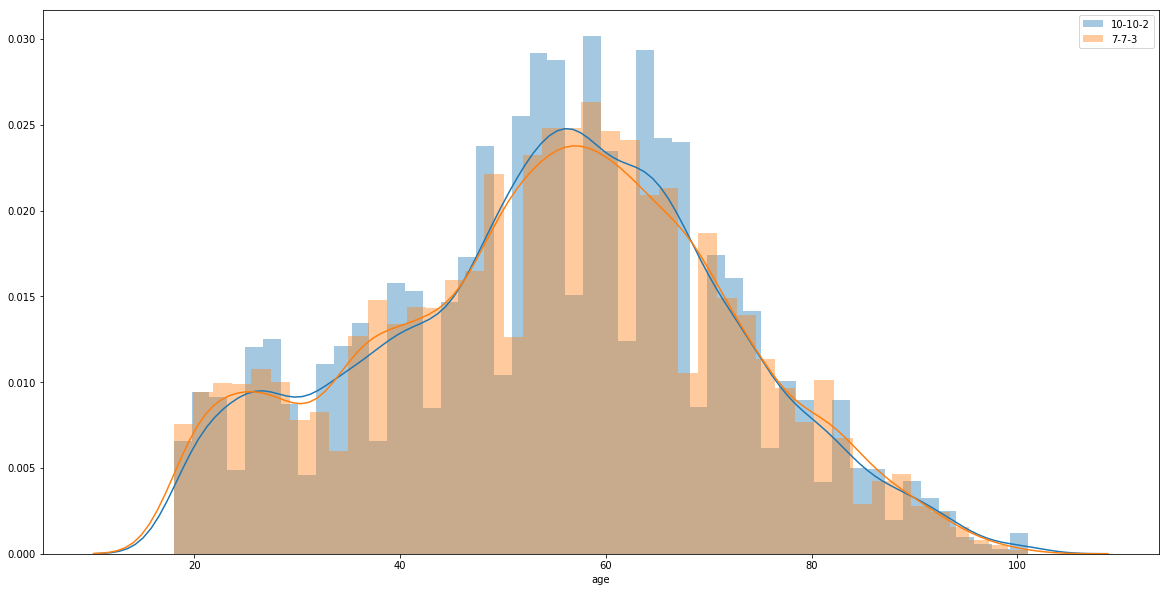

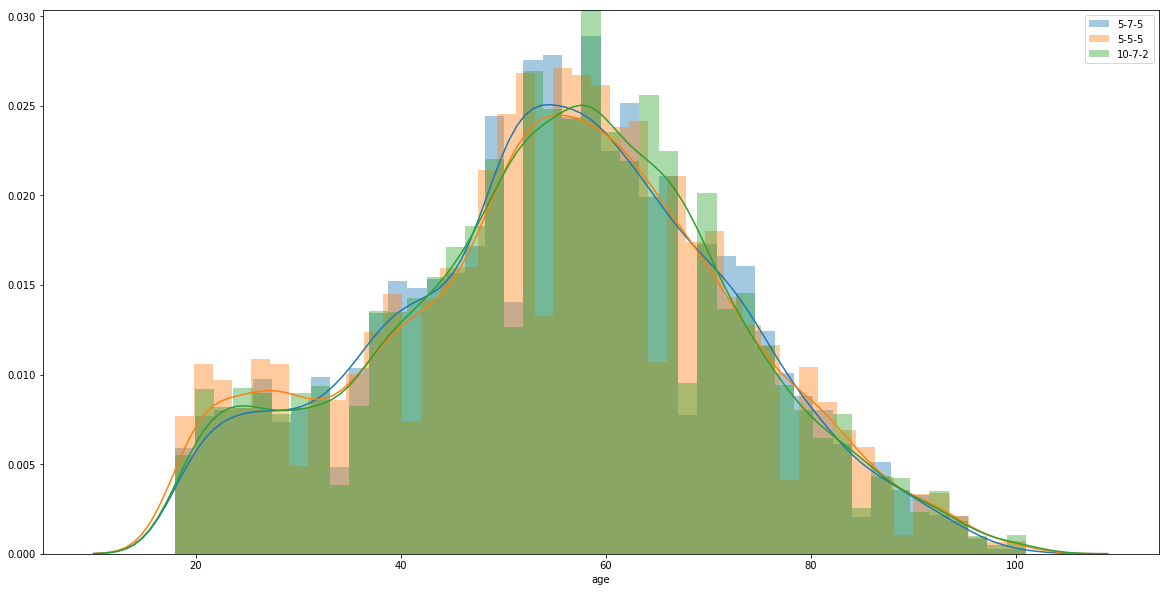

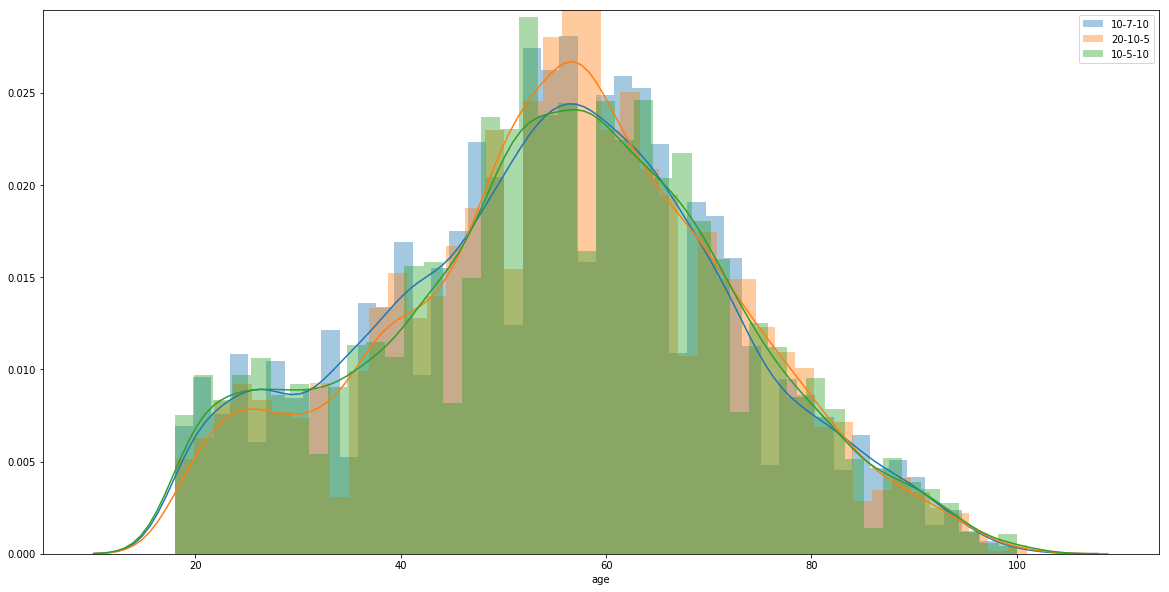

In [103]:
plt.figure(figsize=(20, 10));

sns.distplot(df1[df1.offer_id==7].age,label='10-10-2')
sns.distplot(df1[df1.offer_id==8].age,label='7-7-3')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10));
sns.distplot(df1[df1.offer_id==1].age,label='5-7-5')
sns.distplot(df1[df1.offer_id==5].age,label='5-5-5')
sns.distplot(df1[df1.offer_id==6].age,label='10-7-2')

plt.legend()
plt.show()

plt.figure(figsize=(20, 10));

sns.distplot(df1[df1.offer_id==4].age,label='10-7-10')
sns.distplot(df1[df1.offer_id==9].age,label='20-10-5')
sns.distplot(df1[df1.offer_id==10].age,label='10-5-10')
plt.legend()
plt.show()

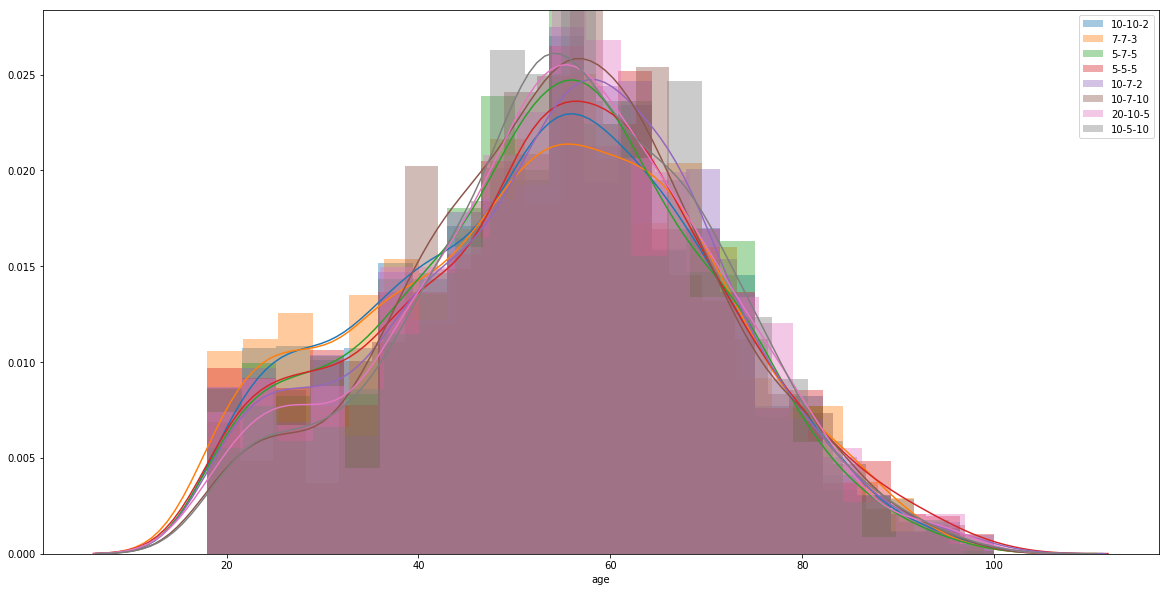

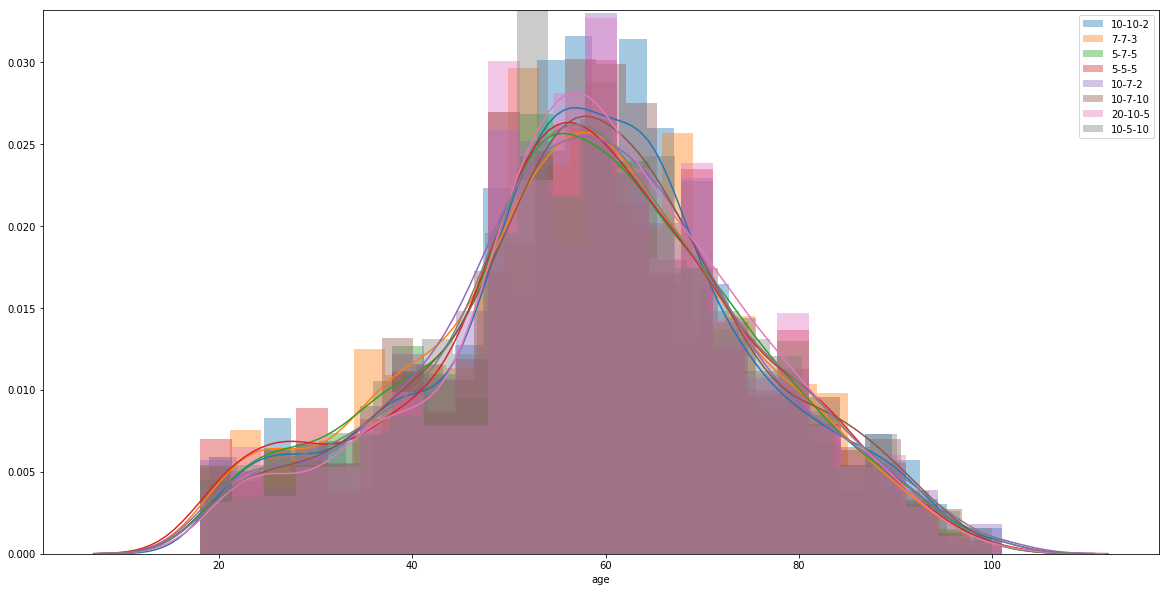

In [104]:
plt.figure(figsize=(20, 10));

sns.distplot(dfoc_m[dfoc_m.offer_id==7].age,label='10-10-2')
sns.distplot(dfoc_m[dfoc_m.offer_id==8].age,label='7-7-3')
sns.distplot(dfoc_m[dfoc_m.offer_id==1].age,label='5-7-5')
sns.distplot(dfoc_m[dfoc_m.offer_id==5].age,label='5-5-5')
sns.distplot(dfoc_m[dfoc_m.offer_id==6].age,label='10-7-2')
sns.distplot(dfoc_m[dfoc_m.offer_id==4].age,label='10-7-10')
sns.distplot(dfoc_m[dfoc_m.offer_id==9].age,label='20-10-5')
sns.distplot(dfoc_m[dfoc_m.offer_id==10].age,label='10-5-10')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10));

sns.distplot(dfoc_f[dfoc_f.offer_id==7].age,label='10-10-2')
sns.distplot(dfoc_f[dfoc_f.offer_id==8].age,label='7-7-3')
sns.distplot(dfoc_f[dfoc_f.offer_id==1].age,label='5-7-5')
sns.distplot(dfoc_f[dfoc_f.offer_id==5].age,label='5-5-5')
sns.distplot(dfoc_f[dfoc_f.offer_id==6].age,label='10-7-2')
sns.distplot(dfoc_f[dfoc_f.offer_id==4].age,label='10-7-10')
sns.distplot(dfoc_f[dfoc_f.offer_id==9].age,label='20-10-5')
sns.distplot(dfoc_f[dfoc_f.offer_id==10].age,label='10-5-10')
plt.legend()
plt.show()

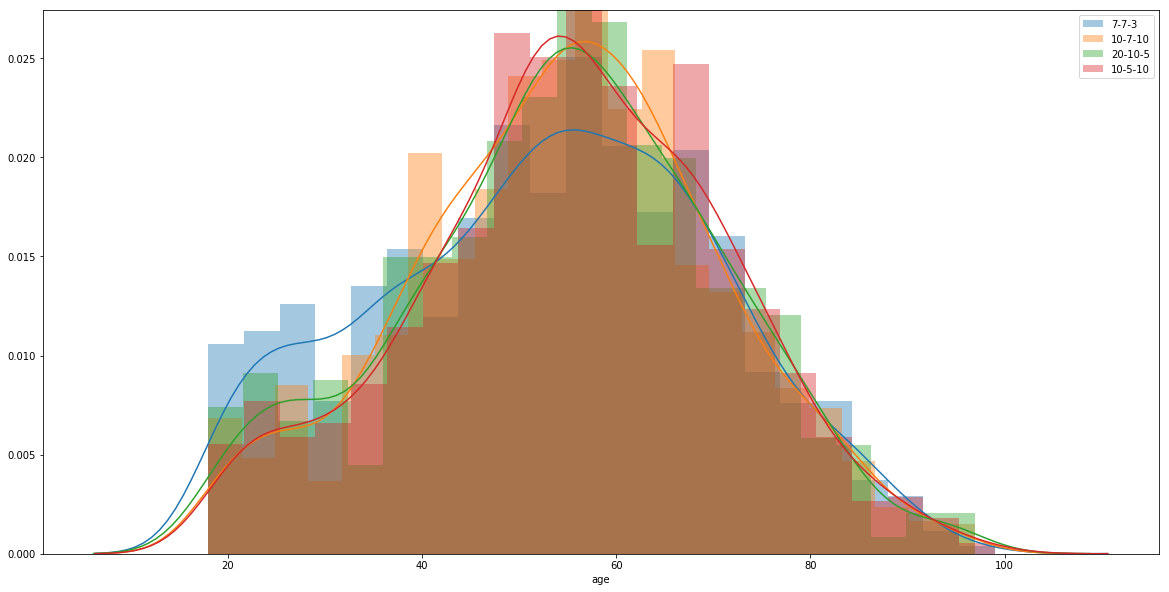

In [105]:
plt.figure(figsize=(20, 10));

#sns.distplot(dfoc_m[dfoc_m.offer_id==7].age,label='10-10-2')
sns.distplot(dfoc_m[dfoc_m.offer_id==8].age,label='7-7-3')
#sns.distplot(dfoc_m[dfoc_m.offer_id==1].age,label='5-7-5')
#sns.distplot(dfoc_m[dfoc_m.offer_id==5].age,label='5-5-5')
#sns.distplot(dfoc_m[dfoc_m.offer_id==6].age,label='10-7-2')
sns.distplot(dfoc_m[dfoc_m.offer_id==4].age,label='10-7-10')
sns.distplot(dfoc_m[dfoc_m.offer_id==9].age,label='20-10-5')
sns.distplot(dfoc_m[dfoc_m.offer_id==10].age,label='10-5-10')
plt.legend()
plt.show()

## Women are older than men acc to age distribution. Offer completion is not sensitive to women's age.
## Younger men prefer low difficulty offers while mid and higher ages(<70) can prefer high difficulty ones.

Text(0.5,0,'Offers')

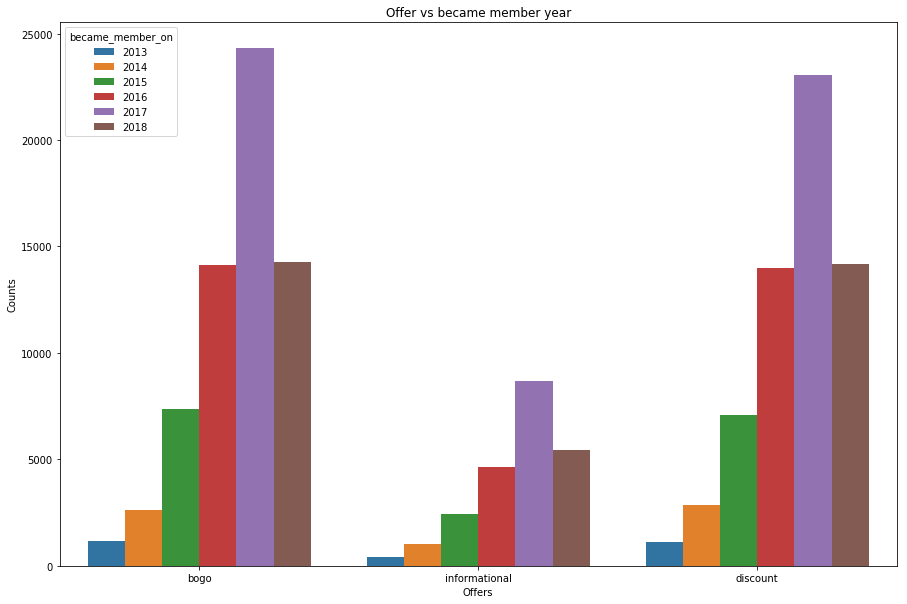

In [106]:
plt.figure(figsize=(15, 10));
sns.countplot(x= "offer_type", hue= "became_member_on", data=df1)
plt.title('Offer vs became member year')
plt.ylabel('Counts')
plt.xlabel('Offers')

Text(0.5,0,'Events')

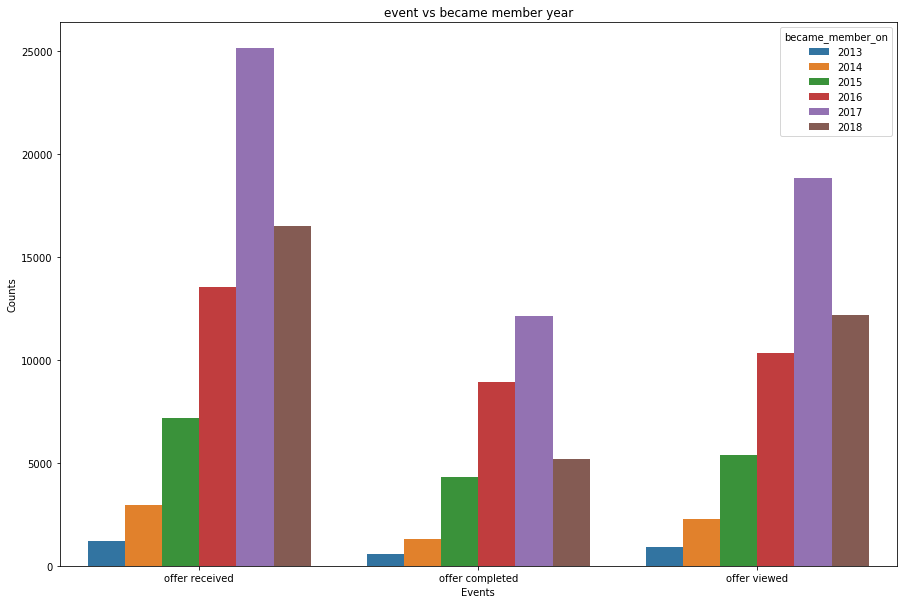

In [107]:
plt.figure(figsize=(15, 10));
sns.countplot(x= "event", hue= "became_member_on", data=df1)
plt.title('event vs became member year')
plt.ylabel('Counts')
plt.xlabel('Events')

## Starbucks uses same strategy for whole users. Offer completion ratio is getting higher for the 3th and 4th year users(2015 and 2016) but getting decrease after 4th year. So the offer type should be more specific for older users to keep retention rate high. 

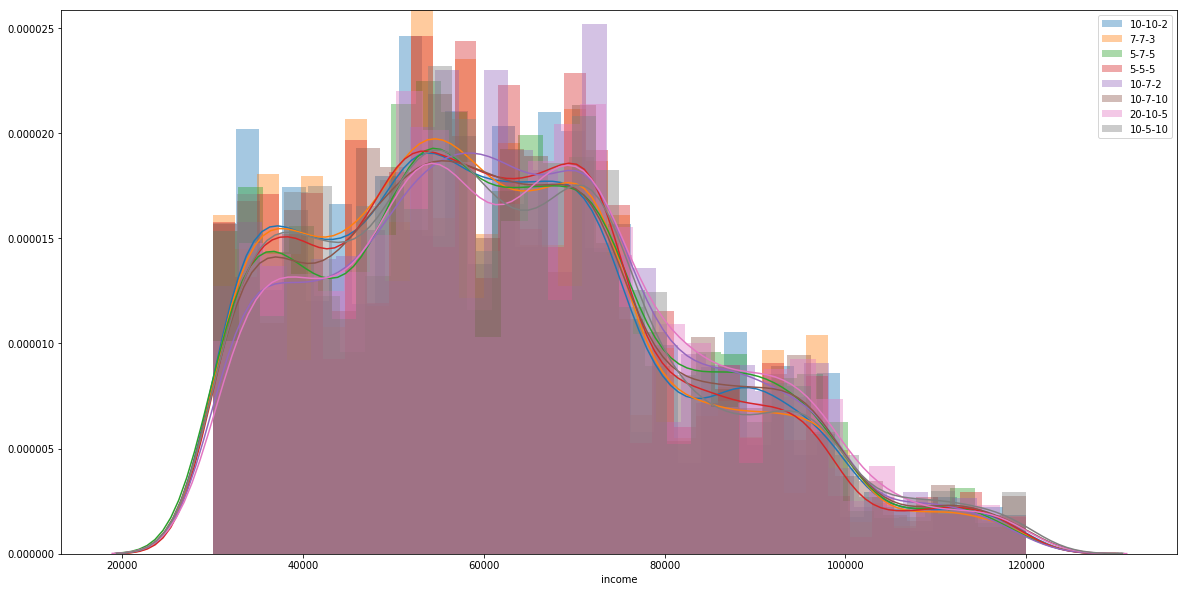

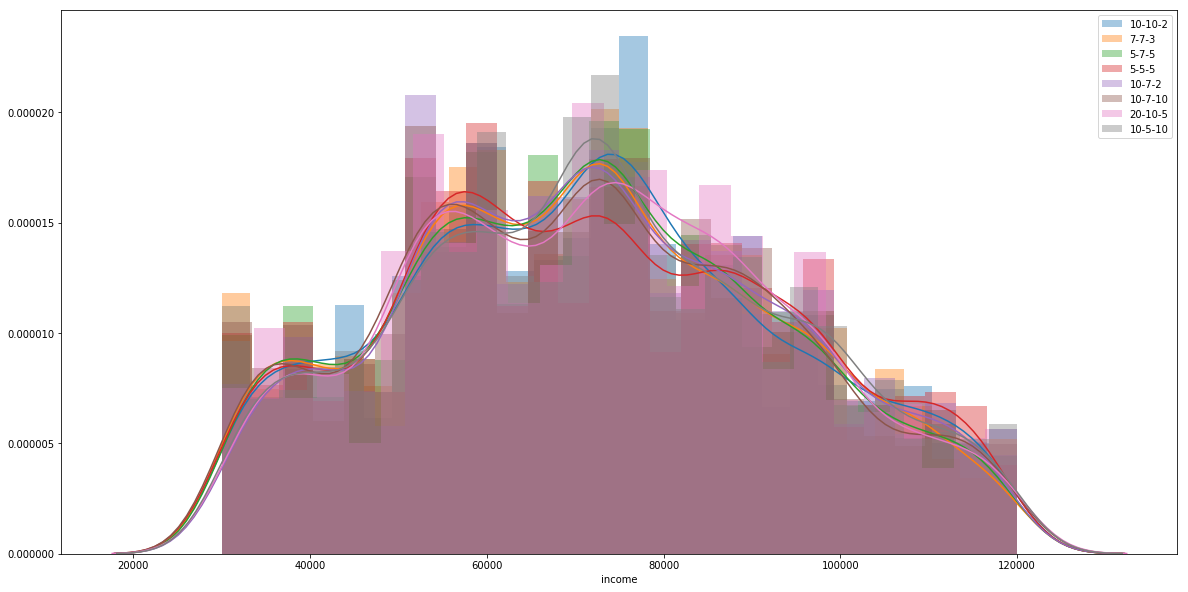

In [108]:
plt.figure(figsize=(20, 10));

sns.distplot(df1_m[df1_m.offer_id==7].income,label='10-10-2')
sns.distplot(df1_m[df1_m.offer_id==8].income,label='7-7-3')
sns.distplot(df1_m[df1_m.offer_id==1].income,label='5-7-5')
sns.distplot(df1_m[df1_m.offer_id==5].income,label='5-5-5')
sns.distplot(df1_m[df1_m.offer_id==6].income,label='10-7-2')
sns.distplot(df1_m[df1_m.offer_id==4].income,label='10-7-10')
sns.distplot(df1_m[df1_m.offer_id==9].income,label='20-10-5')
sns.distplot(df1_m[df1_m.offer_id==10].income,label='10-5-10')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10));

sns.distplot(df1_f[df1_f.offer_id==7].income,label='10-10-2')
sns.distplot(df1_f[df1_f.offer_id==8].income,label='7-7-3')
sns.distplot(df1_f[df1_f.offer_id==1].income,label='5-7-5')
sns.distplot(df1_f[df1_f.offer_id==5].income,label='5-5-5')
sns.distplot(df1_f[df1_f.offer_id==6].income,label='10-7-2')
sns.distplot(df1_f[df1_f.offer_id==4].income,label='10-7-10')
sns.distplot(df1_f[df1_f.offer_id==9].income,label='20-10-5')
sns.distplot(df1_f[df1_f.offer_id==10].income,label='10-5-10')
plt.legend()
plt.show()

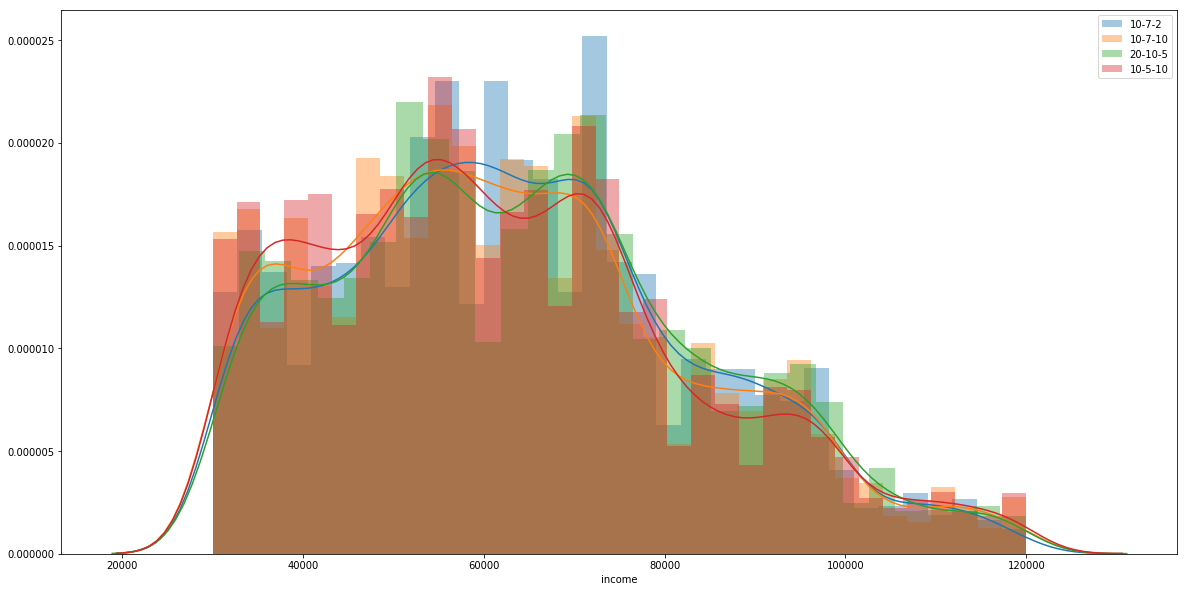

In [109]:
plt.figure(figsize=(20, 10));

#sns.distplot(df1_m[df1_m.offer_id==7].income,label='10-10-2')
#sns.distplot(df1_m[df1_m.offer_id==8].income,label='7-7-3')
#sns.distplot(df1_m[df1_m.offer_id==1].income,label='5-7-5')
#sns.distplot(df1_m[df1_m.offer_id==5].income,label='5-5-5')
sns.distplot(df1_m[df1_m.offer_id==6].income,label='10-7-2')
sns.distplot(df1_m[df1_m.offer_id==4].income,label='10-7-10')
sns.distplot(df1_m[df1_m.offer_id==9].income,label='20-10-5')
sns.distplot(df1_m[df1_m.offer_id==10].income,label='10-5-10')
plt.legend()
plt.show()

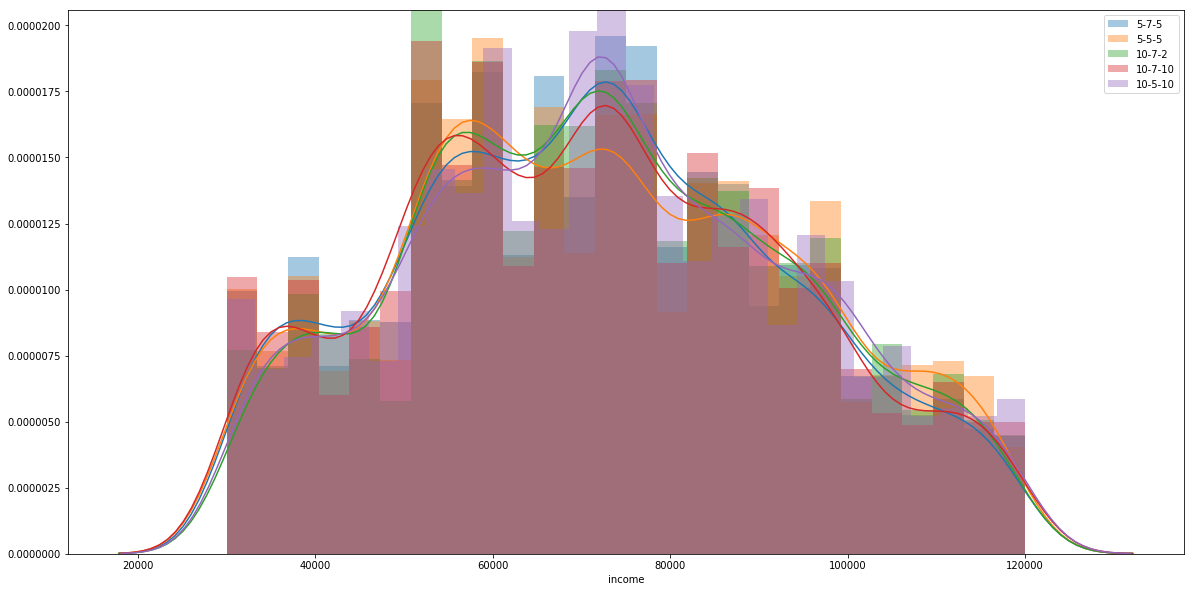

In [110]:
plt.figure(figsize=(20, 10));

#sns.distplot(df1_f[df1_f.offer_id==7].income,label='10-10-2')
#sns.distplot(df1_f[df1_f.offer_id==8].income,label='7-7-3')
sns.distplot(df1_f[df1_f.offer_id==1].income,label='5-7-5')
sns.distplot(df1_f[df1_f.offer_id==5].income,label='5-5-5')
sns.distplot(df1_f[df1_f.offer_id==6].income,label='10-7-2')
sns.distplot(df1_f[df1_f.offer_id==4].income,label='10-7-10')
#sns.distplot(df1_f[df1_f.offer_id==9].income,label='20-10-5')
sns.distplot(df1_f[df1_f.offer_id==10].income,label='10-5-10')
plt.legend()
plt.show()

## men who have 35K to 50K income have different choices on different offers. women who have 65K to 85K income have different choices on different offers. 

In [111]:
# age and income values have been grouped to ease evaluation.

# def ageandincome_interval(df1):
  #   df1.loc[(df1.age >= 10) & (df1.age <= 35), 'age_interval'] = '18-35'
  #   df1.loc[(df1.age > 35) & (df1.age <= 50) , 'age_interval'] = '36-50'
  #   df1.loc[(df1.age > 50) & (df1.age <= 65) , 'age_interval'] = '51-65'
  #   df1.loc[(df1.age > 65) & (df1.age <= 80) , 'age_interval'] = '65-80'
  #   df1.loc[(df1.age > 80), 'age_interval'] = '81+'
    
  #   df1.loc[(df1.income >= 30000) & (df1.income <= 50000), 'income_interval'] = '30-50K'
  #   df1.loc[(df1.income > 50000) & (df1.income <= 70000) , 'income_interval'] = '50-70K'
  #   df1.loc[(df1.income > 70000) & (df1.income <= 90000) , 'income_interval'] = '70-90K'
  #   df1.loc[(df1.income > 90000), 'income_interval'] = '90K+'
    
  #   return df1

In [112]:
# df1=ageandincome_interval(df1)

In [113]:
# I have divided the dataset acc to gender types.
# df1_m=df1[df1['gender']=='M'].reset_index(drop=True)
# df1_f=df1[df1['gender']=='F'].reset_index(drop=True)

In [114]:
# df1.head(1)

In [115]:
# plt.figure(figsize=(15, 10));
# sns.countplot(x= "event", hue= "age_interval", data=df1_m)
# plt.title('Event vs Age Distribution')
# plt.ylabel('Counts')
# plt.xlabel('Event')

In [116]:
# plt.figure(figsize=(15, 10));
# sns.countplot(x= "event", hue= "age_interval", data=df1_f)
# plt.title('Event vs Age Distribution')
# plt.ylabel('Counts')
# plt.xlabel('Event')

In [117]:
# plt.figure(figsize=(15, 10));
# sns.countplot(x= "event", hue= "income_interval", data=df1_m)
# plt.title('Event vs Income Distribution')
# plt.ylabel('Counts')
# plt.xlabel('Event')

In [118]:
# plt.figure(figsize=(15, 10));
# sns.countplot(x= "event", hue= "income_interval", data=df1_f)
# plt.title('Event vs Income Distribution')
# plt.ylabel('Counts')
# plt.xlabel('Event')

In [119]:
# first of all I have checked the whole amount than I have decreased the upper limit to 40. I dismissed the outliers and I would like checj the offer range 5 to 20$.
# df3_40=df3[df3['amount']<40]

# plt.figure(figsize=(15, 10));
# df3_100['amount'].plot(kind='hist', bins=64);

In [120]:
# df1_7=df1[df1['offer_id']==7]
# df1_5=df1[df1['offer_id']==5]

In [121]:
# plt.figure(figsize=(15, 10));
# df1_7['age'].plot(kind='hist', bins=17);

# plt.figure(figsize=(15, 10));
# df1_5['age'].plot(kind='hist', bins=17);


In [122]:
# plt.figure(figsize=(15, 10));
# df1_7['income'].plot(kind='hist', bins=17);

# plt.figure(figsize=(15, 10));
# df1_5['income'].plot(kind='hist', bins=17);


In [123]:
# plt.figure(figsize=(15, 10));

# sns.countplot(x="offer_type", hue="gender", data=df1_5);


In [124]:
# plt.figure(figsize=(15, 10));

# sns.countplot(x="offer_type", hue="gender", data=df1_7);

# Understanding of data to see the difference between transactions and offer sent on demographics wise.

While we check offers sent and transactions data separately, both of them has nearly same demographics.

Age and became member year distribution is nearly same for 2 datasets.

Income has quite different especially higher than 75K for 2 datasets. So that means Starbucks sent more offers as a percentage to 75 to 100K income customers. They targeted this customer set.

The offers were not sent every day. The interval was decreased after 2nd offer. On the other hand, offer receivals are going to decrease after day 0 of offer sent continuously.

In quantity wise, men get more offer than women.

Women has higher income than men according to distribution results.

## Findings

1-) Transactions w/o offers has increased with the increased frequency of offers. So to increase the frequency of offers will attract the customers more. Due to limited size of the data, we could not know the bottlenecks of high duration effect of this action.

2-) Increased offer frequency increases the completion ratio.

3-) Discount and bogo offers have same quantity. Bogo offers views are higher than discount on the other hand discount completion rate is higher.

4-) When difficulty is getting higher the offer completion ratio is worsen as expected for 5 and 10 day durations. On the other hand, if the duration is 7 days then the results is not correlated with difficulty even difficult ones has less rewards.

5-) If difficuilty and reward are same, then completion is getting higher when duration increases as expected.

6-) All offers are sent nearly same day so there is no difference according to time wise. On the other hand, there is no significant differences on statistics between received and viewed ones. I could not detect why there is a difference of receivals ratio for 7 day duration events even it is not logical.

7-) Women's completion ratio is significantly higher than men. Especially on discount, women completion ratio is higher than view.

8-) Women and men have same top3 offer choice. 

9-) Womens have less sensitivity to offer type but offer type is important for men. If the difficulty is higher than 1dolar per day then men's tendecy to complete offer decreases significantly.

10-) Offer completion is not sensitive to women's age.

11-) Younger men prefer low difficulty offers while mid and higher ages(<70) can prefer high difficulty ones.

12-) Starbucks uses same strategy for whole users as a "become a member year" wise. Offer completion ratio is getting higher for the 3th and 4th year users(2015 and 2016) but getting decrease after 4th year. So the offer type should be more specific for older users to keep retention rate high. 

13-) Men who have 35K to 50K income have different choices on different offers. Women who have 65K to 85K income have different choices on different offers. 

## In conclusion of visualization results

Men customer who were 20-45 years old responded to offer 7 and 8 higher than other offers.

Men customer who were 45-60 years old responded to other offers rather than 7 and 8.

Men customer who have 35K to 50K income responded to other offers rather than 4,6,9.

-----

Women are less sensitive to offer types but they have a tendecy to discount offers. Increase discount offers for women.

Women customer who have 65K to 85K income responded to offer 1 and 10.

-------

Focus on offer 7,8,5 and 1 in general. Retention rate is higher.

3th and 4th year members has higher retention rate in general.

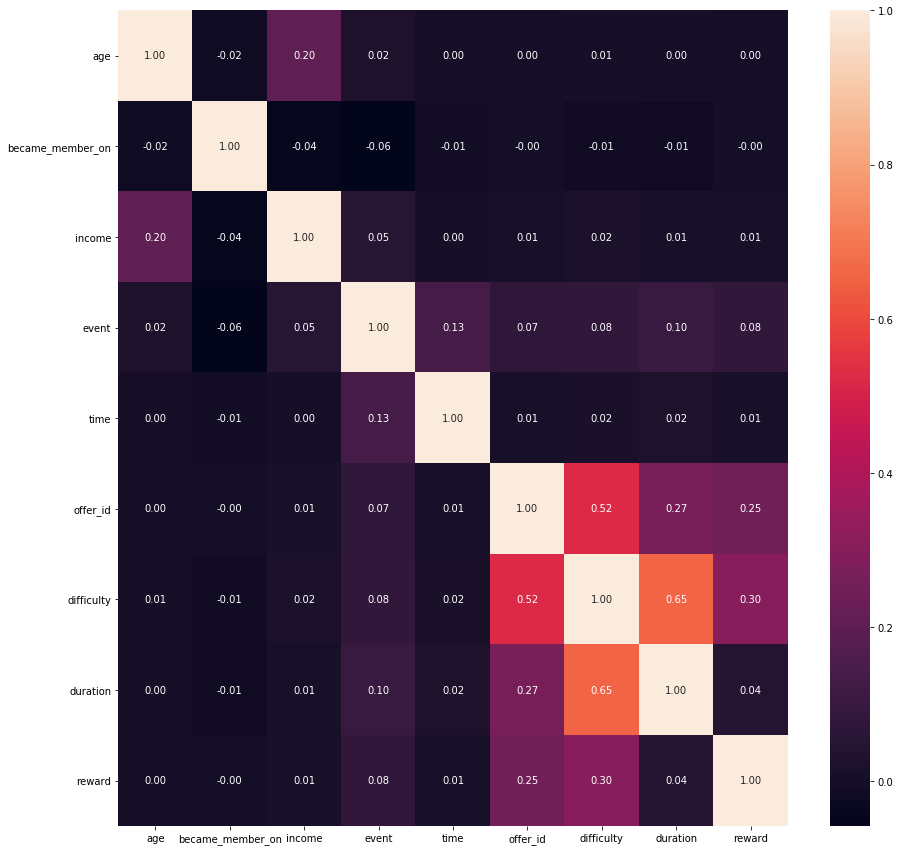

In [125]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df1_model.corr(method="kendall"),annot = True,fmt = "0.2f")

In [126]:
df1_model.head()

,age,became_member_on,gender,income,event,time,offer_id,difficulty,duration,offer_type,reward
0,55,2017,-1,112000.0,0,408,1,5,168,1,5
1,55,2017,-1,112000.0,2,528,1,5,168,1,5
2,75,2017,-1,100000.0,0,0,1,5,168,1,5
3,75,2017,-1,100000.0,1,6,1,5,168,1,5
4,75,2017,-1,100000.0,2,132,1,5,168,1,5


In [127]:
#df1_model_Q1=df1_model[df1_model['gender']==-1].reset_index(drop=True)

# "M"] = 1
# "F"] = -1
# "O"] = 0

In [128]:
df1_model_Q2=df1_model[df1_model['gender']==1].reset_index(drop=True)


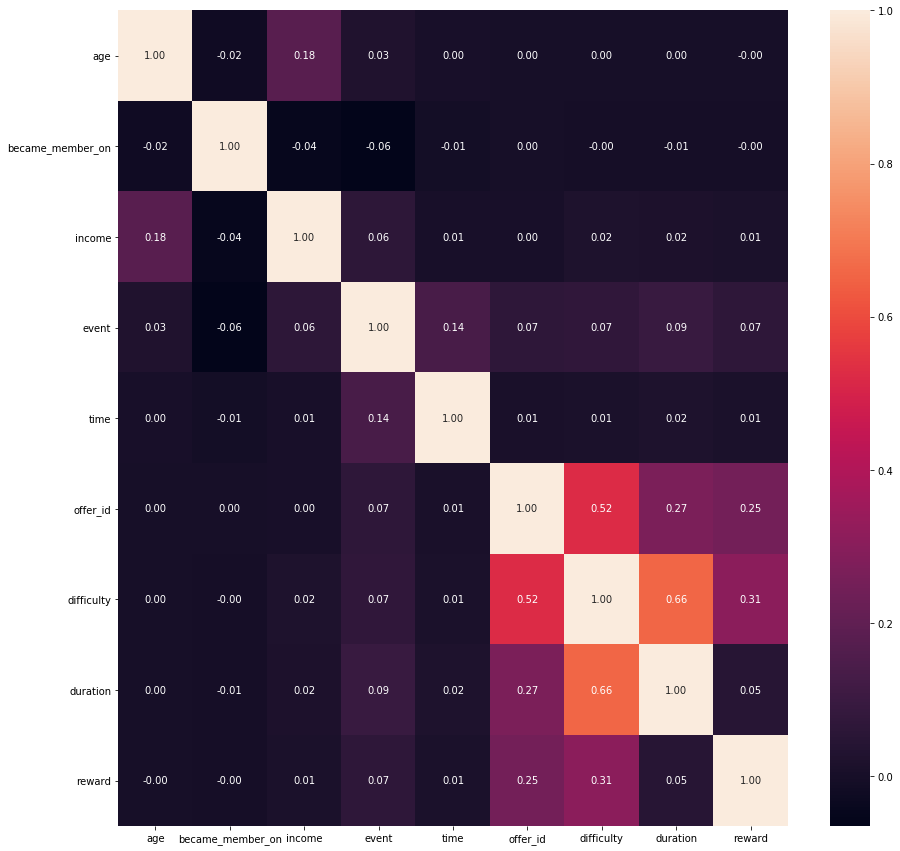

In [129]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df1_model_Q2.corr(method="kendall"),annot = True,fmt = "0.2f")

## Modelling

In [130]:
df1_model_y=df1_model.copy(deep = True)

In [131]:
X = df1_model.drop(columns = ["event"])


In [132]:
y = df1_model.drop(columns = ["age","became_member_on","gender","income","time","offer_id","difficulty","duration","offer_type","reward",])

In [133]:
y.head()

,event
0,0
1,2
2,0
3,1
4,2


In [134]:
scaler = MinMaxScaler()

def testandtrain(X,y,category=False, channel =False):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape  
    
    X_train.age = scaler.fit_transform(X_train.age.values.reshape(-1, 1))
    X_test.age = scaler.fit_transform(X_test.age.values.reshape(-1, 1))

    X_train.became_member_on = scaler.fit_transform(X_train.became_member_on.values.reshape(-1, 1))
    X_test.became_member_on = scaler.fit_transform(X_test.became_member_on.values.reshape(-1, 1))

    X_train.income = scaler.fit_transform(X_train.income.values.reshape(-1, 1))
    X_test.income = scaler.fit_transform(X_test.income.values.reshape(-1, 1))
    
    X_train.time = scaler.fit_transform(X_train.time.values.reshape(-1, 1))
    X_test.time = scaler.fit_transform(X_test.time.values.reshape(-1, 1))
        
    X_train.offer_id = scaler.fit_transform(X_train.offer_id.values.reshape(-1, 1))
    X_test.offer_id = scaler.fit_transform(X_test.offer_id.values.reshape(-1, 1))
        
    X_train.difficulty = scaler.fit_transform(X_train.difficulty.values.reshape(-1, 1))
    X_test.difficulty = scaler.fit_transform(X_test.difficulty.values.reshape(-1, 1))
                
    X_train.duration = scaler.fit_transform(X_train.duration.values.reshape(-1, 1))
    X_test.duration = scaler.fit_transform(X_test.duration.values.reshape(-1, 1))
  
    X_train.reward = scaler.fit_transform(X_train.reward.values.reshape(-1, 1))
    X_test.reward = scaler.fit_transform(X_test.reward.values.reshape(-1, 1))
  
    X_train.gender = scaler.fit_transform(X_train.gender.values.reshape(-1, 1))
    X_test.gender = scaler.fit_transform(X_test.gender.values.reshape(-1, 1))

    X_train.offer_type = scaler.fit_transform(X_train.offer_type.values.reshape(-1, 1))
    X_test.offer_type = scaler.fit_transform(X_test.offer_type.values.reshape(-1, 1))

  
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = testandtrain(X,y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [135]:
X_train.shape

(99699, 10)

In [136]:
y_train.shape

(99699, 1)

In [137]:
X_test.shape

(49106, 10)

In [138]:
y_test.shape

(49106, 1)

In [139]:
X_train.describe()

,age,became_member_on,gender,income,time,offer_id,difficulty,duration,offer_type,reward
count,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000
mean,0.442876,0.716077,0.564930,0.404894,0.496824,0.522946,0.394985,0.517811,0.639670,0.445486
std,0.206771,0.237387,0.491991,0.238856,0.277380,0.311124,0.252223,0.304172,0.355073,0.337286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.301205,0.600000,0.000000,0.233333,0.235294,0.333333,0.250000,0.285714,0.500000,0.200000
50%,0.457831,0.800000,1.000000,0.388889,0.571429,0.555556,0.500000,0.571429,0.500000,0.500000
75%,0.590361,0.800000,1.000000,0.566667,0.714286,0.777778,0.500000,0.571429,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


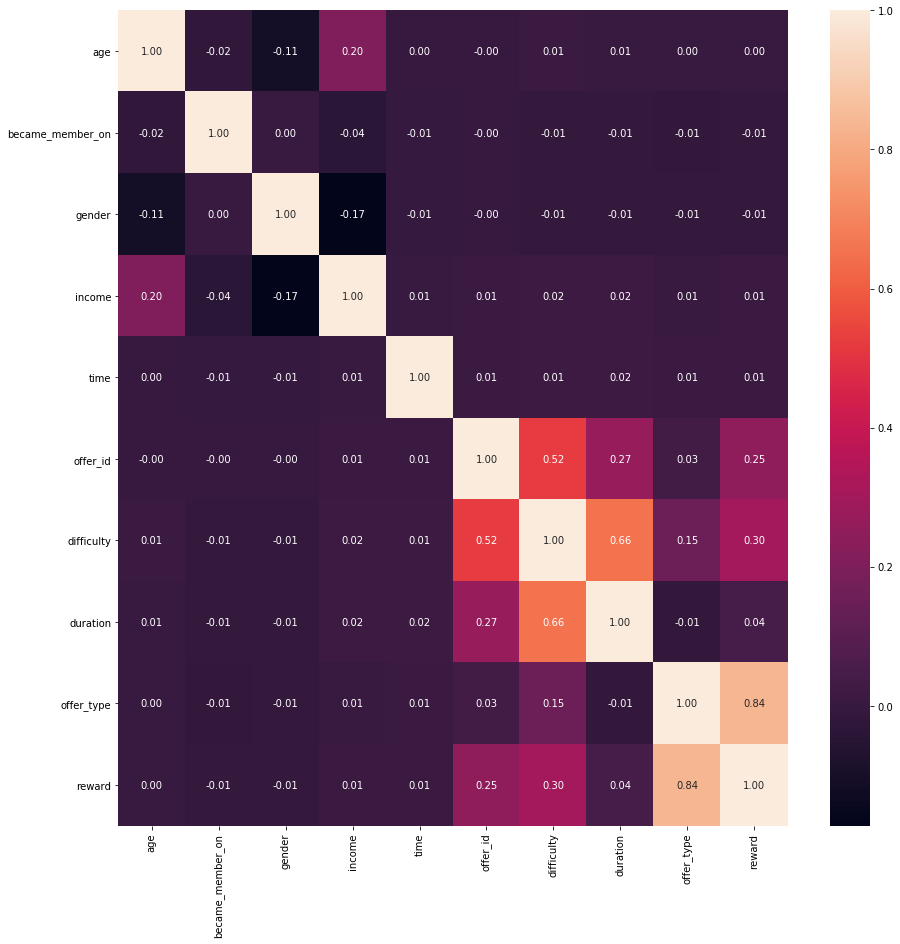

In [140]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(X_test.corr(method="kendall"),annot = True,fmt = "0.2f")

In [141]:
def train_test(model):
   
    train_prediction =  (model.fit(X_train, y_train)).predict(X_train)
    test_predictions = (model.fit(X_train, y_train)).predict(X_test)
    train_f1_score =  accuracy_score(y_train, train_prediction)*100
    test_f1_score= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    
    return train_f1_score, test_f1_score, test_predictions

In [142]:
dtc = DecisionTreeClassifier(random_state = 1)
dtc_train_f1_score, dtc_test_f1_score,dtc_test_predictions = train_test(dtc)

In [143]:
rfc = RandomForestClassifier(random_state = 1)
rfc_train_f1_score, rfc_test_f1_score,rfc_test_predictions = train_test(rfc)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [144]:
models = {'Model': ['DecisionTreeClassifier','RandomForestClassifier'], 
          'train F1 score ':[dtc_train_f1_score, rfc_train_f1_score], 
          'test F1 score': [dtc_test_f1_score, rfc_test_f1_score] }
          
results = pd.DataFrame(models)
results

,Model,train F1 score,test F1 score
0,DecisionTreeClassifier,92.951785,63.493259
1,RandomForestClassifier,91.457286,56.842341


In [145]:
X_test.head()

,age,became_member_on,gender,income,time,offer_id,difficulty,duration,offer_type,reward
93490,0.216867,1.0,1.0,0.200000,0.294118,0.666667,0.50,1.000000,0.5,0.2
79279,0.277108,0.0,1.0,0.544444,0.705882,0.555556,0.50,0.571429,0.5,0.2
5980,0.518072,0.2,1.0,0.233333,0.638655,0.000000,0.25,0.571429,1.0,0.5
124850,0.277108,0.6,0.0,0.233333,0.705882,0.888889,1.00,1.000000,0.5,0.5
46034,0.590361,0.6,1.0,0.655556,0.470588,0.333333,0.50,0.571429,1.0,1.0


In [146]:
y_test.head()

,event
93490,2
79279,0
5980,1
124850,0
46034,0


In [147]:
dtc_test_predictions

array([1, 0, 1, ..., 1, 0, 2])

In [148]:
pred_out=pd.DataFrame(dtc_test_predictions, columns=['predicted_outcome'])
pred_out.head()

,predicted_outcome
0,1
1,0
2,1
3,0
4,0
